In [5]:
%load_ext autoreload
%autoreload 2

import sys
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from src.data_loader import SubjectData, load_subject, load_all_subjects
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
from scipy.stats import friedmanchisquare, wilcoxon
from statsmodels.stats.multitest import multipletests

from pathlib import Path
import matlab.engine
import scipy.io


sys.path.append('pointprocess/build/')
# Now we can import the Python byndings from the pointprocess library
from pointprocess import (compute_single_regression, compute_full_regression, compute_spectral_analysis, Distributions, Result, RegressionResult, get_ks_coords, Stats)
from src.utils import preprocess_rr, stitch_rr_phases, plot_rr_and_hrv_grid, plot_lfhf_power_grid, plot_ks_goodness_of_fit_grid, plot_all_hrv_summaries, stitch_rr_phases
# %matplotlib widget

In [6]:
BASELINE_PHASE = 0
EXPERIMENT_PHASE = 1

## 1. Exploration on One Subject

Load single subject and explore available data.

In [4]:
# Subject i01 - EMO data
i01_emo = load_subject('i13', 'EMO')
i01_emo.summary()

{'subject_id': 'i13',
 'condition': 'EMO',
 'file_path': 'data/i13/i13_EMO.mat',
 'num_phases': 2,
 'data_fields': {'EEG_ph': (1, 2),
  'Physio_ph': (1, 2),
  'RR_ph': (1, 2),
  'RRi_ph': (1, 2),
  'T_RR_ph': (1, 2),
  'T_RRi_ph': (1, 2),
  'videos': (1, 3)},
 'num_videos': 3}

#### 1.1 Load and visualize EEG data

In [5]:
eeg = i01_emo.get_eeg_data(EXPERIMENT_PHASE)
eeg

/Users/zeyad/Documents/projects/brain-heart-microstates-of-emotional-arousal/data_loader.py:268: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations, verbose=False)


<RawArray | 19 x 247499 (495.0 s), ~35.9 MiB, data loaded>

Plot EEG timeseries

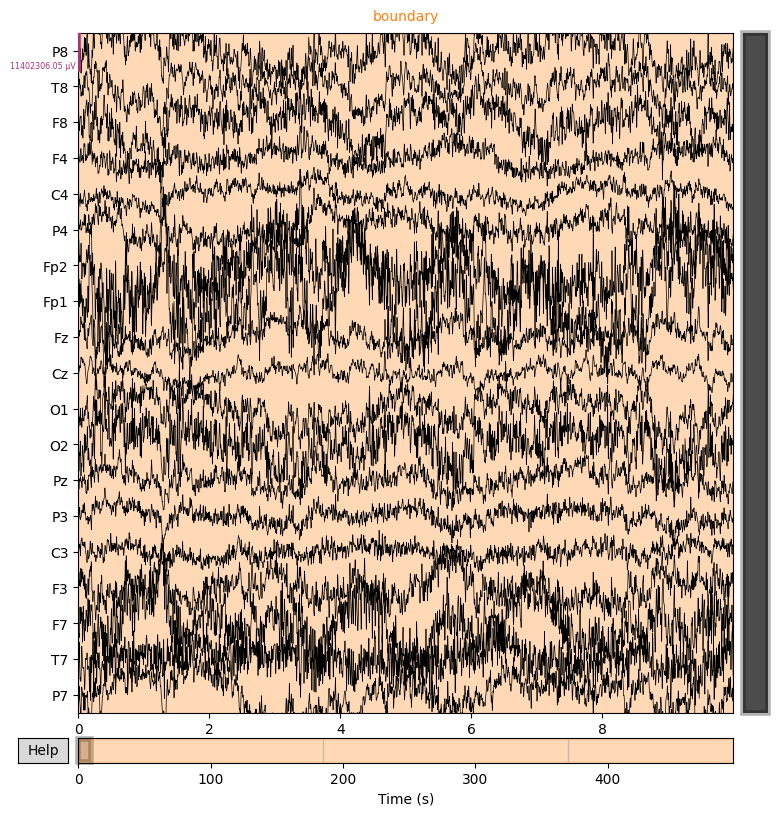

In [7]:
# Plot EEG data
eeg.plot(scalings='auto', title='EEG Data - Subject i01 EMO');

Compute and plot power spectral density (PSD)

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


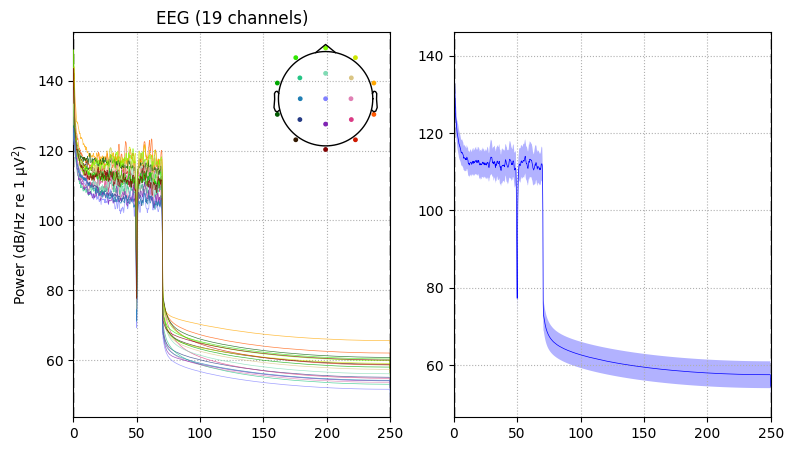

In [18]:
spectrum = eeg.compute_psd()

fig, ax = plt.subplots(1, 2, figsize=(9, 5))
spectrum.plot(axes = ax[0]);
spectrum.plot(axes = ax[1], average = True, color='blue')

Plot topomap

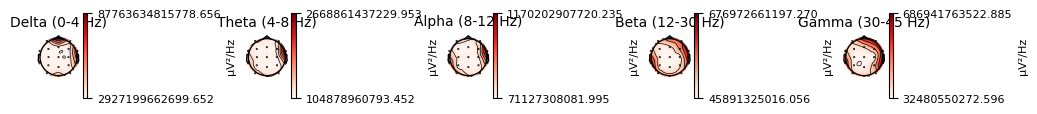

In [20]:
spectrum.plot_topomap(extrapolate='head', outlines='head');

#### 1.2 Load and visualize RR intervals

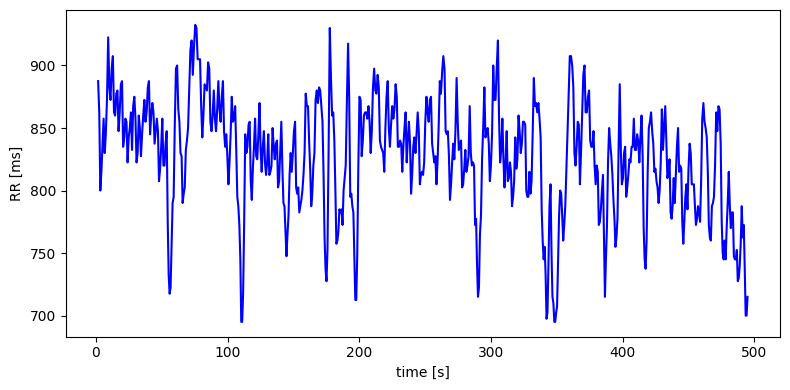

In [21]:
rr_times = i01_emo.get_rr_timestamps(EXPERIMENT_PHASE).flatten()

plt.figure(figsize=(8, 4))
plt.plot(rr_times[1:], 1000*np.diff(rr_times),"b")
plt.xlabel('time [s]')
plt.ylabel('RR [ms]')
plt.tight_layout()
plt.show()

#### 1.3 Point process HRV analysis

##### 1.3.1 Stationary inverse gaussian regression

In [22]:
# Extract RR times in the interval [200, 300] seconds
time_mask = (rr_times >= 200) & (rr_times <= 300)
rr_times_subset = rr_times[time_mask]

result_single_regression = compute_single_regression(
    events = rr_times_subset,
    ar_order = 9,
    has_theta0 = True,
    right_censoring = False,
    alpha = 0.02,
    distribution=Distributions.InverseGaussian,
    max_iter=10000
    )

Spectral analysis

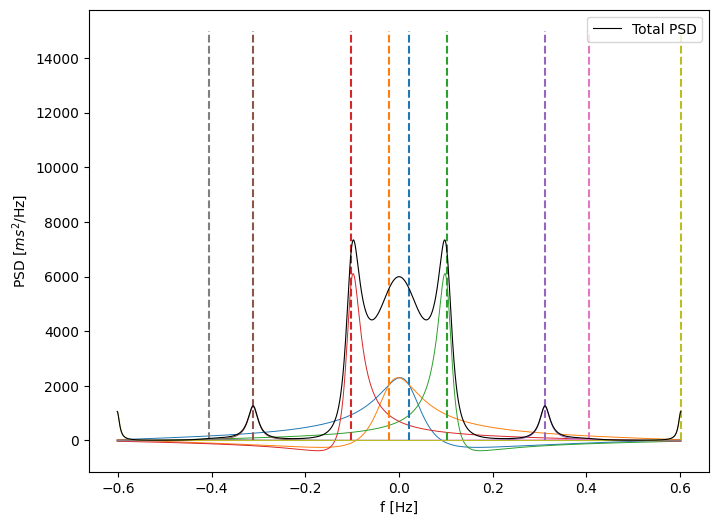

In [23]:
thetap = result_single_regression.thetap
mean_interval = result_single_regression.mean_interval
kappa = result_single_regression.kappa
variance = result_single_regression.sigma**2


# Retrieve spectral info
analysis = compute_spectral_analysis(thetap, mean_interval, variance, aggregate=False)

# Plot stuff
plt.figure(figsize=(8,6),dpi=100)
colors = []
for comp in analysis.comps:
    p = plt.plot(analysis.frequencies, np.real(comp),linewidth=0.7)
    colors.append(p[-1].get_color())
    
for i in range(len(analysis.poles)):
    plt.vlines(analysis.poles[i].frequency,0,15000,colors[i],"--")
    
plt.plot(analysis.frequencies, analysis.powers, "k-",linewidth=0.8,label="Total PSD")
plt.xlabel("f [Hz]")
plt.ylabel("PSD [$ms^2$/Hz]")
plt.legend()
plt.show()

##### 1.3.2 Time-varying inverse gaussian regression

In [24]:
# Fit Inverse Gaussian distribution to RR by moving a 60.0 seconds windows and shifting it by 0.005 s at each step.
# The mean of the ditribution will bi given by a 9th order AR model
result = compute_full_regression(
    events=rr_times,
    window_length=60.0,
    delta=0.005,
    ar_order=9,
    has_theta0=True,
    right_censoring=True,
    alpha = 0.02,
    distribution=Distributions.InverseGaussian,
    max_iter = 1000
)

# Compute spectral info
result.compute_hrv_indices()

# Convert result to dictionary...
d = result.to_dict()

Processing: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l
Computing HRV indices: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l


Plot first moment of distribution over time

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/var/folders/17/rqwtx3ln267d3s23tr72t9nh0000gn/T/ipykernel_1320/2179730894.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$ [ms]")


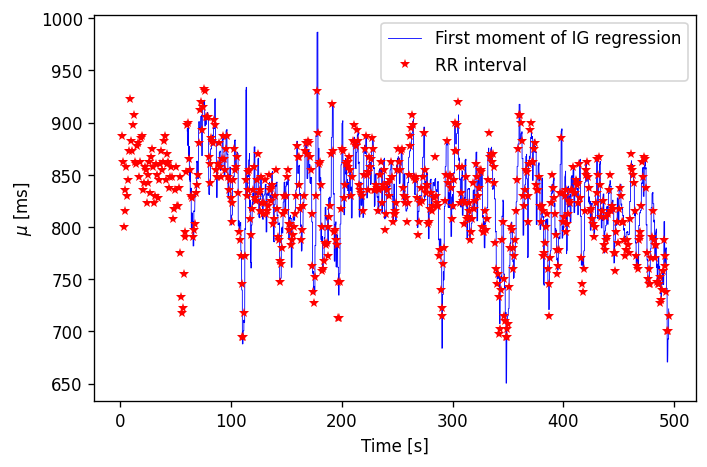

In [29]:
# Plot first moment of the distribution in time, along with the discrete RR intervals 
plt.figure(figsize=(6,4),dpi=120)
plt.plot(d["Time"],d["Mu"] * 1000,"b",linewidth=0.5,label="First moment of IG regression")
plt.xlabel("Time [s]")
plt.ylabel("$\mu$ [ms]")
plt.plot(rr_times[1:],np.diff(rr_times) * 1000,"r*",mew=0.01,label="RR interval")
plt.tight_layout()
plt.legend()
plt.show()

Plot HF and LF power over time

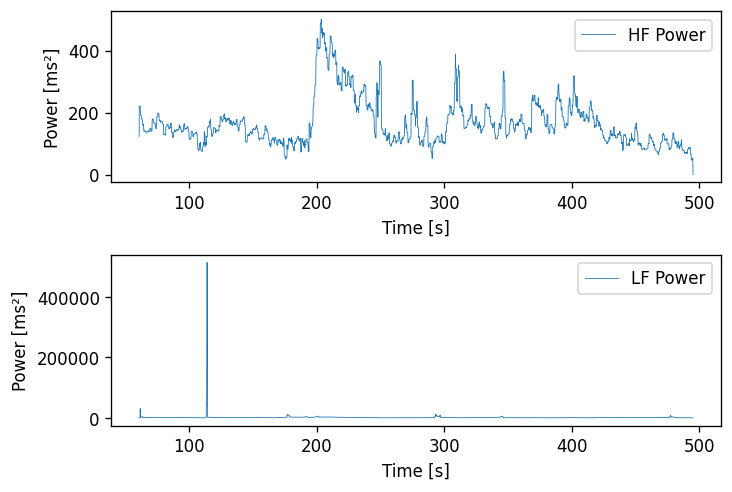

In [32]:
time = d["Time"]
hf_power = d["powHF"]
lf_power = d["powLF"]

fig, ax = plt.subplots(2,1, figsize=(6,4),dpi=120)

ax[0].plot(time, hf_power, linewidth=0.5, label="HF Power")
ax[1].plot(time, lf_power, linewidth=0.5, label="LF Power")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Power [ms²]")
fig.tight_layout()
ax[0].legend()
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Power [ms²]")
ax[1].legend()
plt.show()

## 2. Multi-Subject Analysis

Load all available subjects for EMO condition

In [7]:
# Load all subjects with EMO condition
all_subjects = load_all_subjects(condition='EMO')

print(f"Loaded {len(all_subjects)} subjects.")

Loaded 24 subjects.


Store EEG channel info for later use

In [8]:
channel_info = all_subjects['i01'].get_eeg_data(EXPERIMENT_PHASE).info

/Users/zeyad/Documents/projects/brain-heart-microstates-of-emotional-arousal/src/data_loader.py:268: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations, verbose=False)


### 2.1 Cardiovascular Activity

#### 2.1.1 Compute HRV and Visualize Summaries for All Subjects

In [ ]:
# ============================================================================
# Step 1: Compute HRV for all subjects (once per subject)
# Stitch together baseline and experiment phases (continuous recording)
# ============================================================================
print("\nComputing HRV for all subjects with stitched phases...")
hrv_results = {}

for subject_id, subject in all_subjects.items():
    
    try:
        # Get RR times for both phases
        baseline_rr = subject.get_rr_timestamps(BASELINE_PHASE).flatten()
        experiment_rr = subject.get_rr_timestamps(EXPERIMENT_PHASE).flatten()
        
        # Stitch together: baseline followed by experiment
        rr_times_full, stitch_info = stitch_rr_phases(baseline_rr, experiment_rr)
        
        # Compute HRV with spectral indices on the full stitched series
        result = compute_full_regression(
            events=rr_times_full,
            window_length=60.0,
            delta=0.005,
            ar_order=9,
            has_theta0=True,
            right_censoring=True,
            alpha=0.02,
            distribution=Distributions.InverseGaussian,
            max_iter=1000
        )
        result.compute_hrv_indices()
        
        # Store results
        hrv_results[subject_id] = {
            'rr_times': rr_times_full,
            'hrv_dict': result.to_dict(),
            'taus': result.taus,
            'rr_info': stitch_info,  # Store for later reference
        }
        
    except Exception as e:
        hrv_results[subject_id] = None
        print(f"  ✗ {subject_id}: {e}")



Computing HRV for all subjects with stitched phases...
Processing: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :01s<00m:00s] ?25l
Computing HRV indices: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l
Processing: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :01s<00m:00s] 
Computing HRV indices: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l
Processing: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :01s<00m:00s] ?25l
Computing HRV indices: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l
Processing: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :02s<00m:00s] ?25l
Computing HRV indices: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l
Processing: [■■■■■■■■■■■■■■■■■■■--------------------------------

Save results as PDF files

In [8]:
plot_all_hrv_summaries(hrv_results, all_subjects, video_time_shift=185.0, save_path='hrv_summaries_all_subjects.pdf')


1. Plotting RR intervals & HRV first moment (μ)...
2. Plotting VLF Power...
3. Plotting LF Power...
4. Plotting HF Power...
5. Plotting LF/HF Ratio...
6. Plotting KS goodness-of-fit...

✓ All visualizations complete!
✓ Saved plots to: hrv_summaries_all_subjects.pdf


{'rr_mu': <Figure size 2500x1500 with 25 Axes>,
 'vlf': <Figure size 2500x1500 with 25 Axes>,
 'lf': <Figure size 2500x1500 with 25 Axes>,
 'hf': <Figure size 2500x1500 with 25 Axes>,
 'lf_hf': <Figure size 2500x1500 with 25 Axes>,
 'ks': <Figure size 2500x1500 with 25 Axes>}

#### 2.1.2 RR Intervals Preprocessing and Hyperparameter Search

Clean RR interval series for all subjects.
1. Remove outliers based on fixed thresholds [300 ms < RR < 1500 ms].
2. Detect and remove ectopic beats using the Malik algorithm.
3. Interpolate missing values using linear interpolation.

Hyperparameter search for point process model on `window_length`, `ar_order`, and `alpha` parameters.
| Parameter       | Values to test          |
|-----------------|-------------------------|
| window_length   | [60, 90, 120]           |
| ar_order        | [5, 6, 7, 8, 9]         |
| alpha           | [0, 0.01, 0.02]         |

Results saved as PDFs and hyperparamters selected based on visual inspection of results.

In [ ]:
# Define parameter grid for hyperparameter search
window_length = [60.0, 90.0, 120.0]
ar_order = [5, 6, 7, 8, 9]
alpha = [0, 0.01, 0.02]


for wl in window_length:
    for ao in ar_order:
        for a in alpha:
            print(f"  Testing params: window_length={wl}, ar_order={ao}, alpha={a}")
            corrected_hrv_results = {}
            for subject_id, subject in all_subjects.items():
    
                try:
                    # Get RR times for both phases
                    baseline_rr_raw = subject.get_rr_timestamps(BASELINE_PHASE).flatten()
                    experiment_rr_raw = subject.get_rr_timestamps(EXPERIMENT_PHASE).flatten()
                    
                    # Stitch together: baseline followed by experiment
                    rr_times_full, stitch_info = stitch_rr_phases(baseline_rr_raw, experiment_rr_raw)

                    # Preprocess the stitched RR series
                    rr_times_clean, clean_info = preprocess_rr(rr_times=rr_times_full, high_rri=1500)
                    
                    # Compute HRV with spectral indices on the full stitched and cleaned series
                    result = compute_full_regression(
                        events=rr_times_clean,
                        window_length=wl,
                        delta=0.005,
                        ar_order=ao,
                        has_theta0=True,
                        right_censoring=True,
                        alpha=a,
                        distribution=Distributions.InverseGaussian,
                        max_iter=1000
                    )
                    result.compute_hrv_indices()
                    
                    # Store results
                    corrected_hrv_results[subject_id] = {
                        'rr_times': rr_times_clean,
                        'hrv_dict': result.to_dict(),
                        'taus': result.taus,
                        'rr_info': stitch_info,  # Store for later reference
                        'clean_info': clean_info  # Store preprocessing info
                    }

                    
                except Exception as e:
                    corrected_hrv_results[subject_id] = None
                    print(f"  ✗ {subject_id}: {e}")

            plot_all_hrv_summaries(corrected_hrv_results, all_subjects, video_time_shift=185.0, save_path=f'hp_search_results/w{wl}_ar{ao}_a{a}.pdf')

  Testing params: window_length=60.0, ar_order=5, alpha=0
0 outlier(s) have been deleted.
1 ectopic beat(s) have been deleted with malik rule.
Processing: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :01s<00m:00s] ?25l
Computing HRV indices: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] 
0 outlier(s) have been deleted.
2 ectopic beat(s) have been deleted with malik rule.
Processing: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :01s<00m:00s] ?25l
Computing HRV indices: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
Processing: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :01s<00m:00s] ?25l
Computing HRV indices: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l
2 outlier(s) have been delet

Selected optimal hyperparameters after search:
`window_length=90.0`
`ar_order=7`
`alpha=0.01`

0 outlier(s) have been deleted.
1 ectopic beat(s) have been deleted with malik rule.
Processing: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :01s<00m:00s] ?25l
Computing HRV indices: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l
0 outlier(s) have been deleted.
2 ectopic beat(s) have been deleted with malik rule.
Processing: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :01s<00m:00s] ?25l
Computing HRV indices: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
Processing: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :01s<00m:00s] ?25l
Computing HRV indices: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l
2 outlier(s) have been deleted.
The outlier(s) value(s) are : [15.000000000071623,

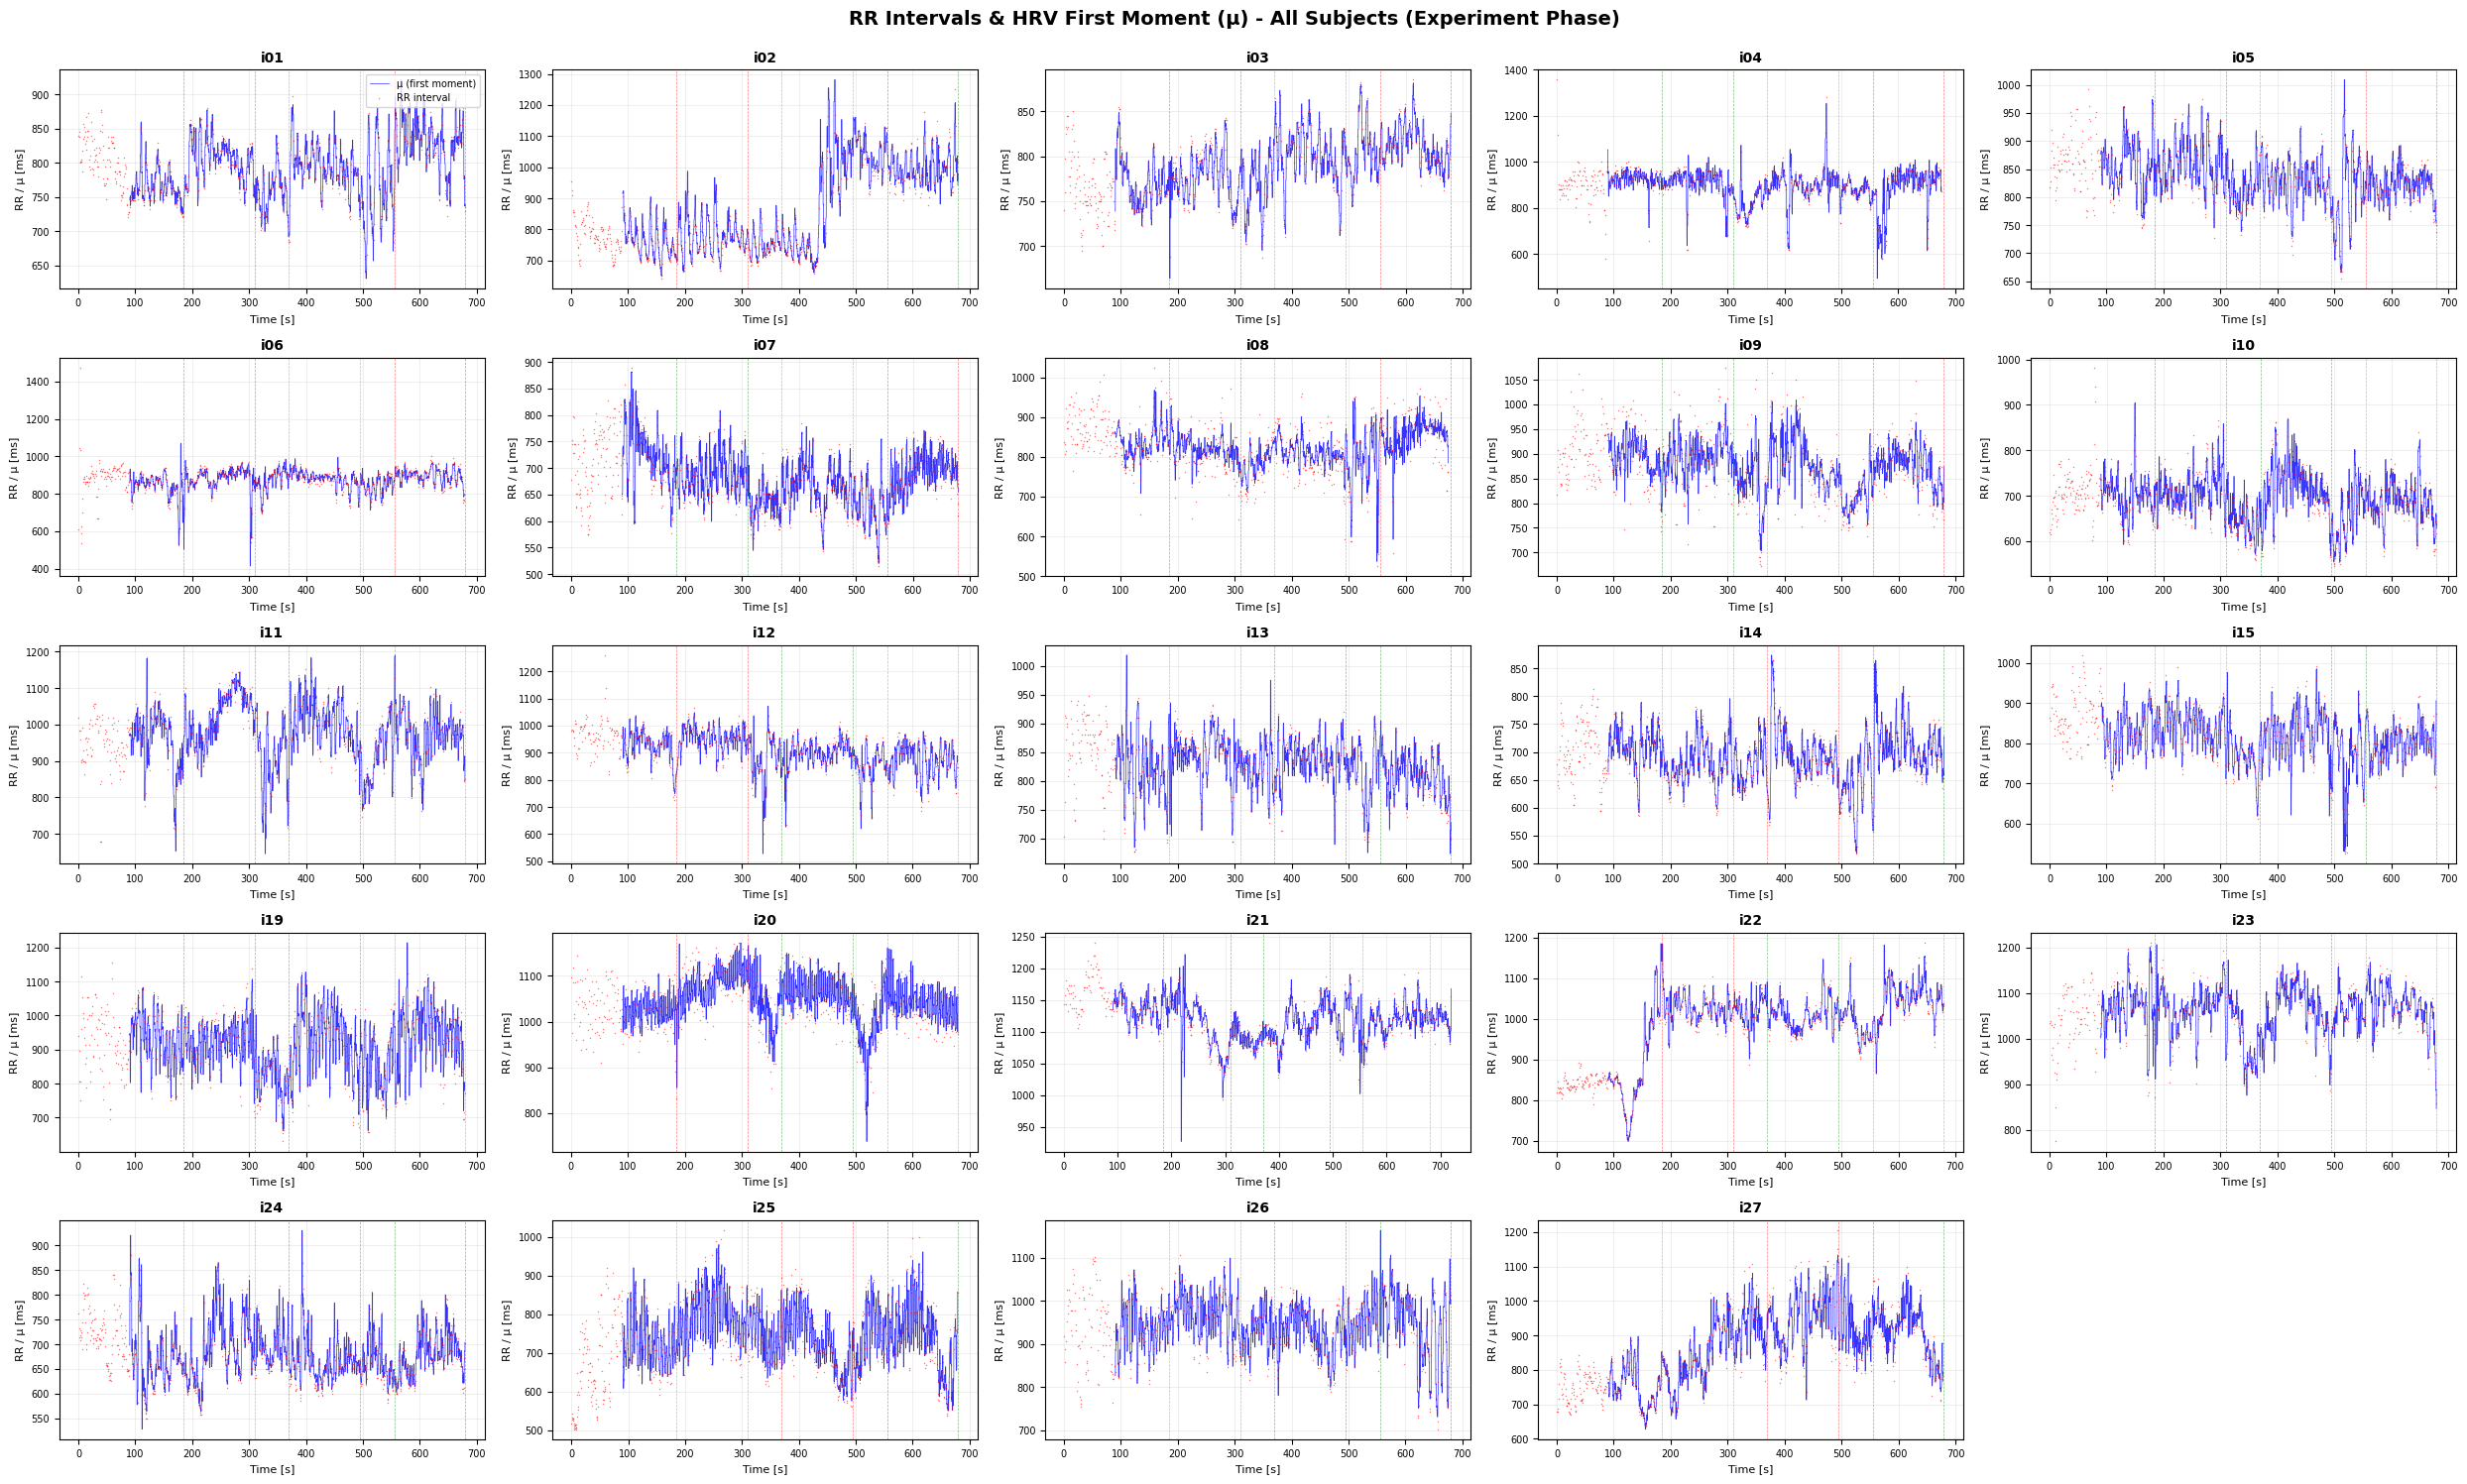

2. Plotting VLF Power...


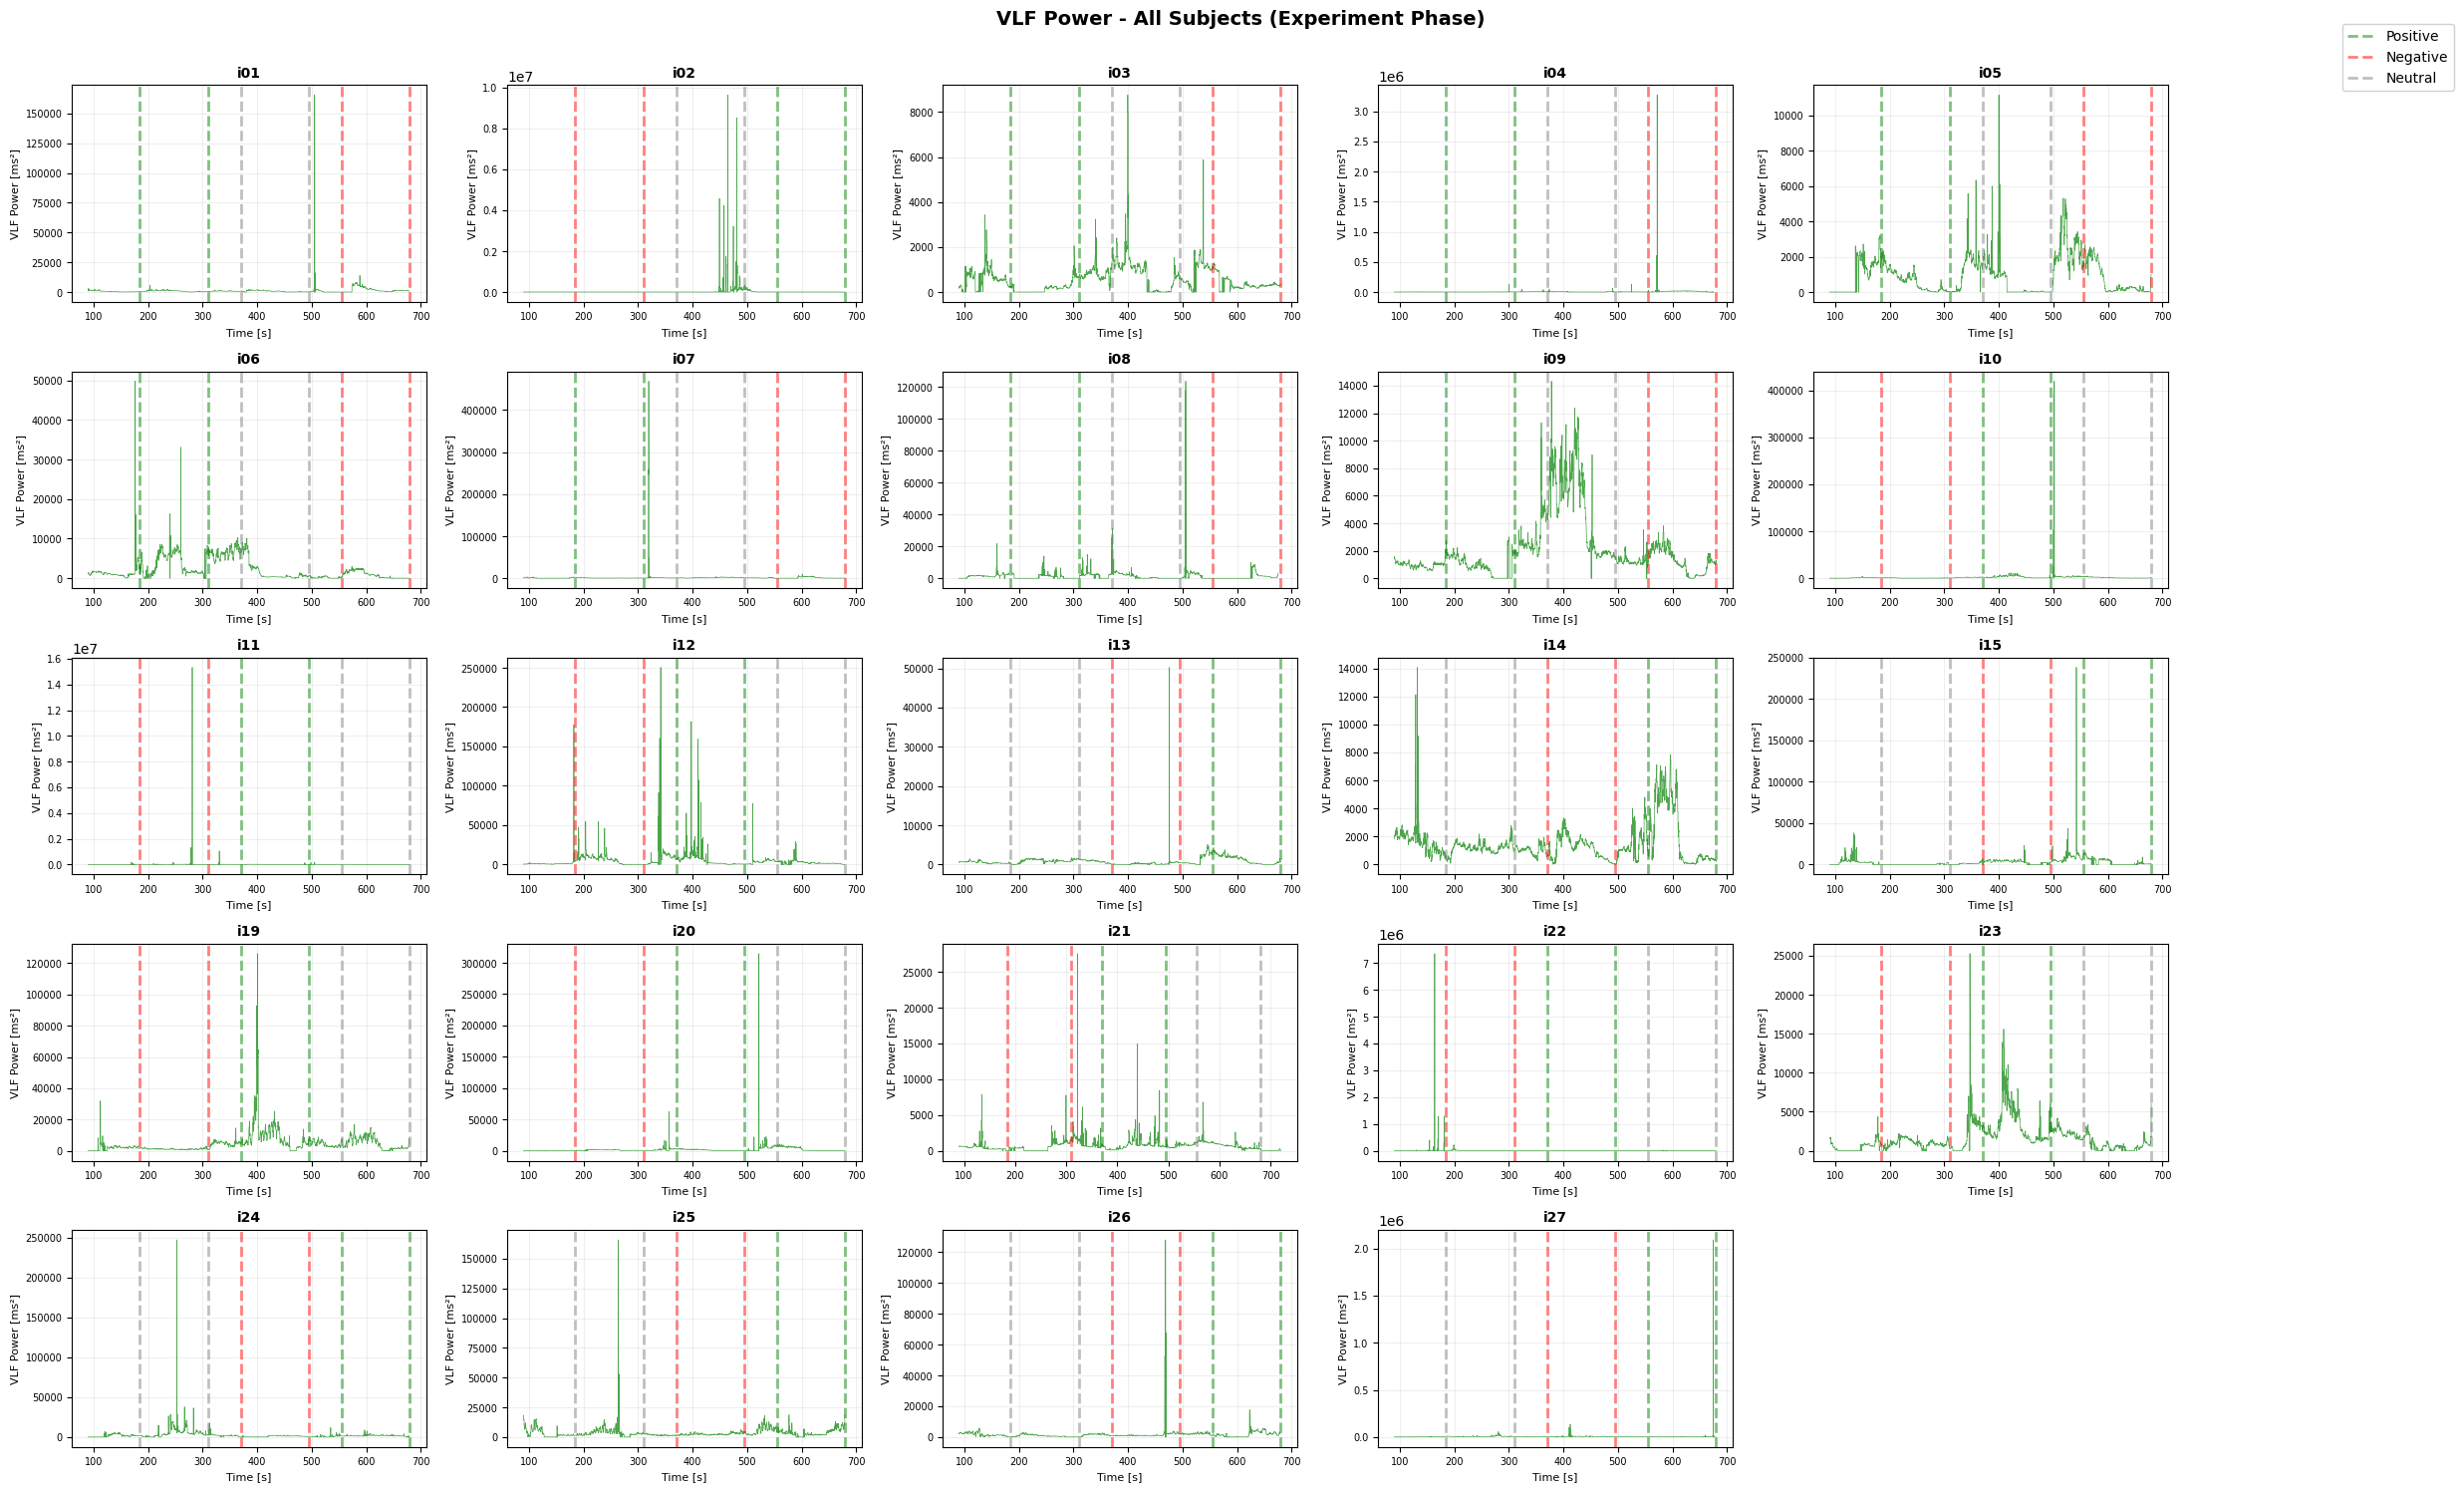

3. Plotting LF Power...


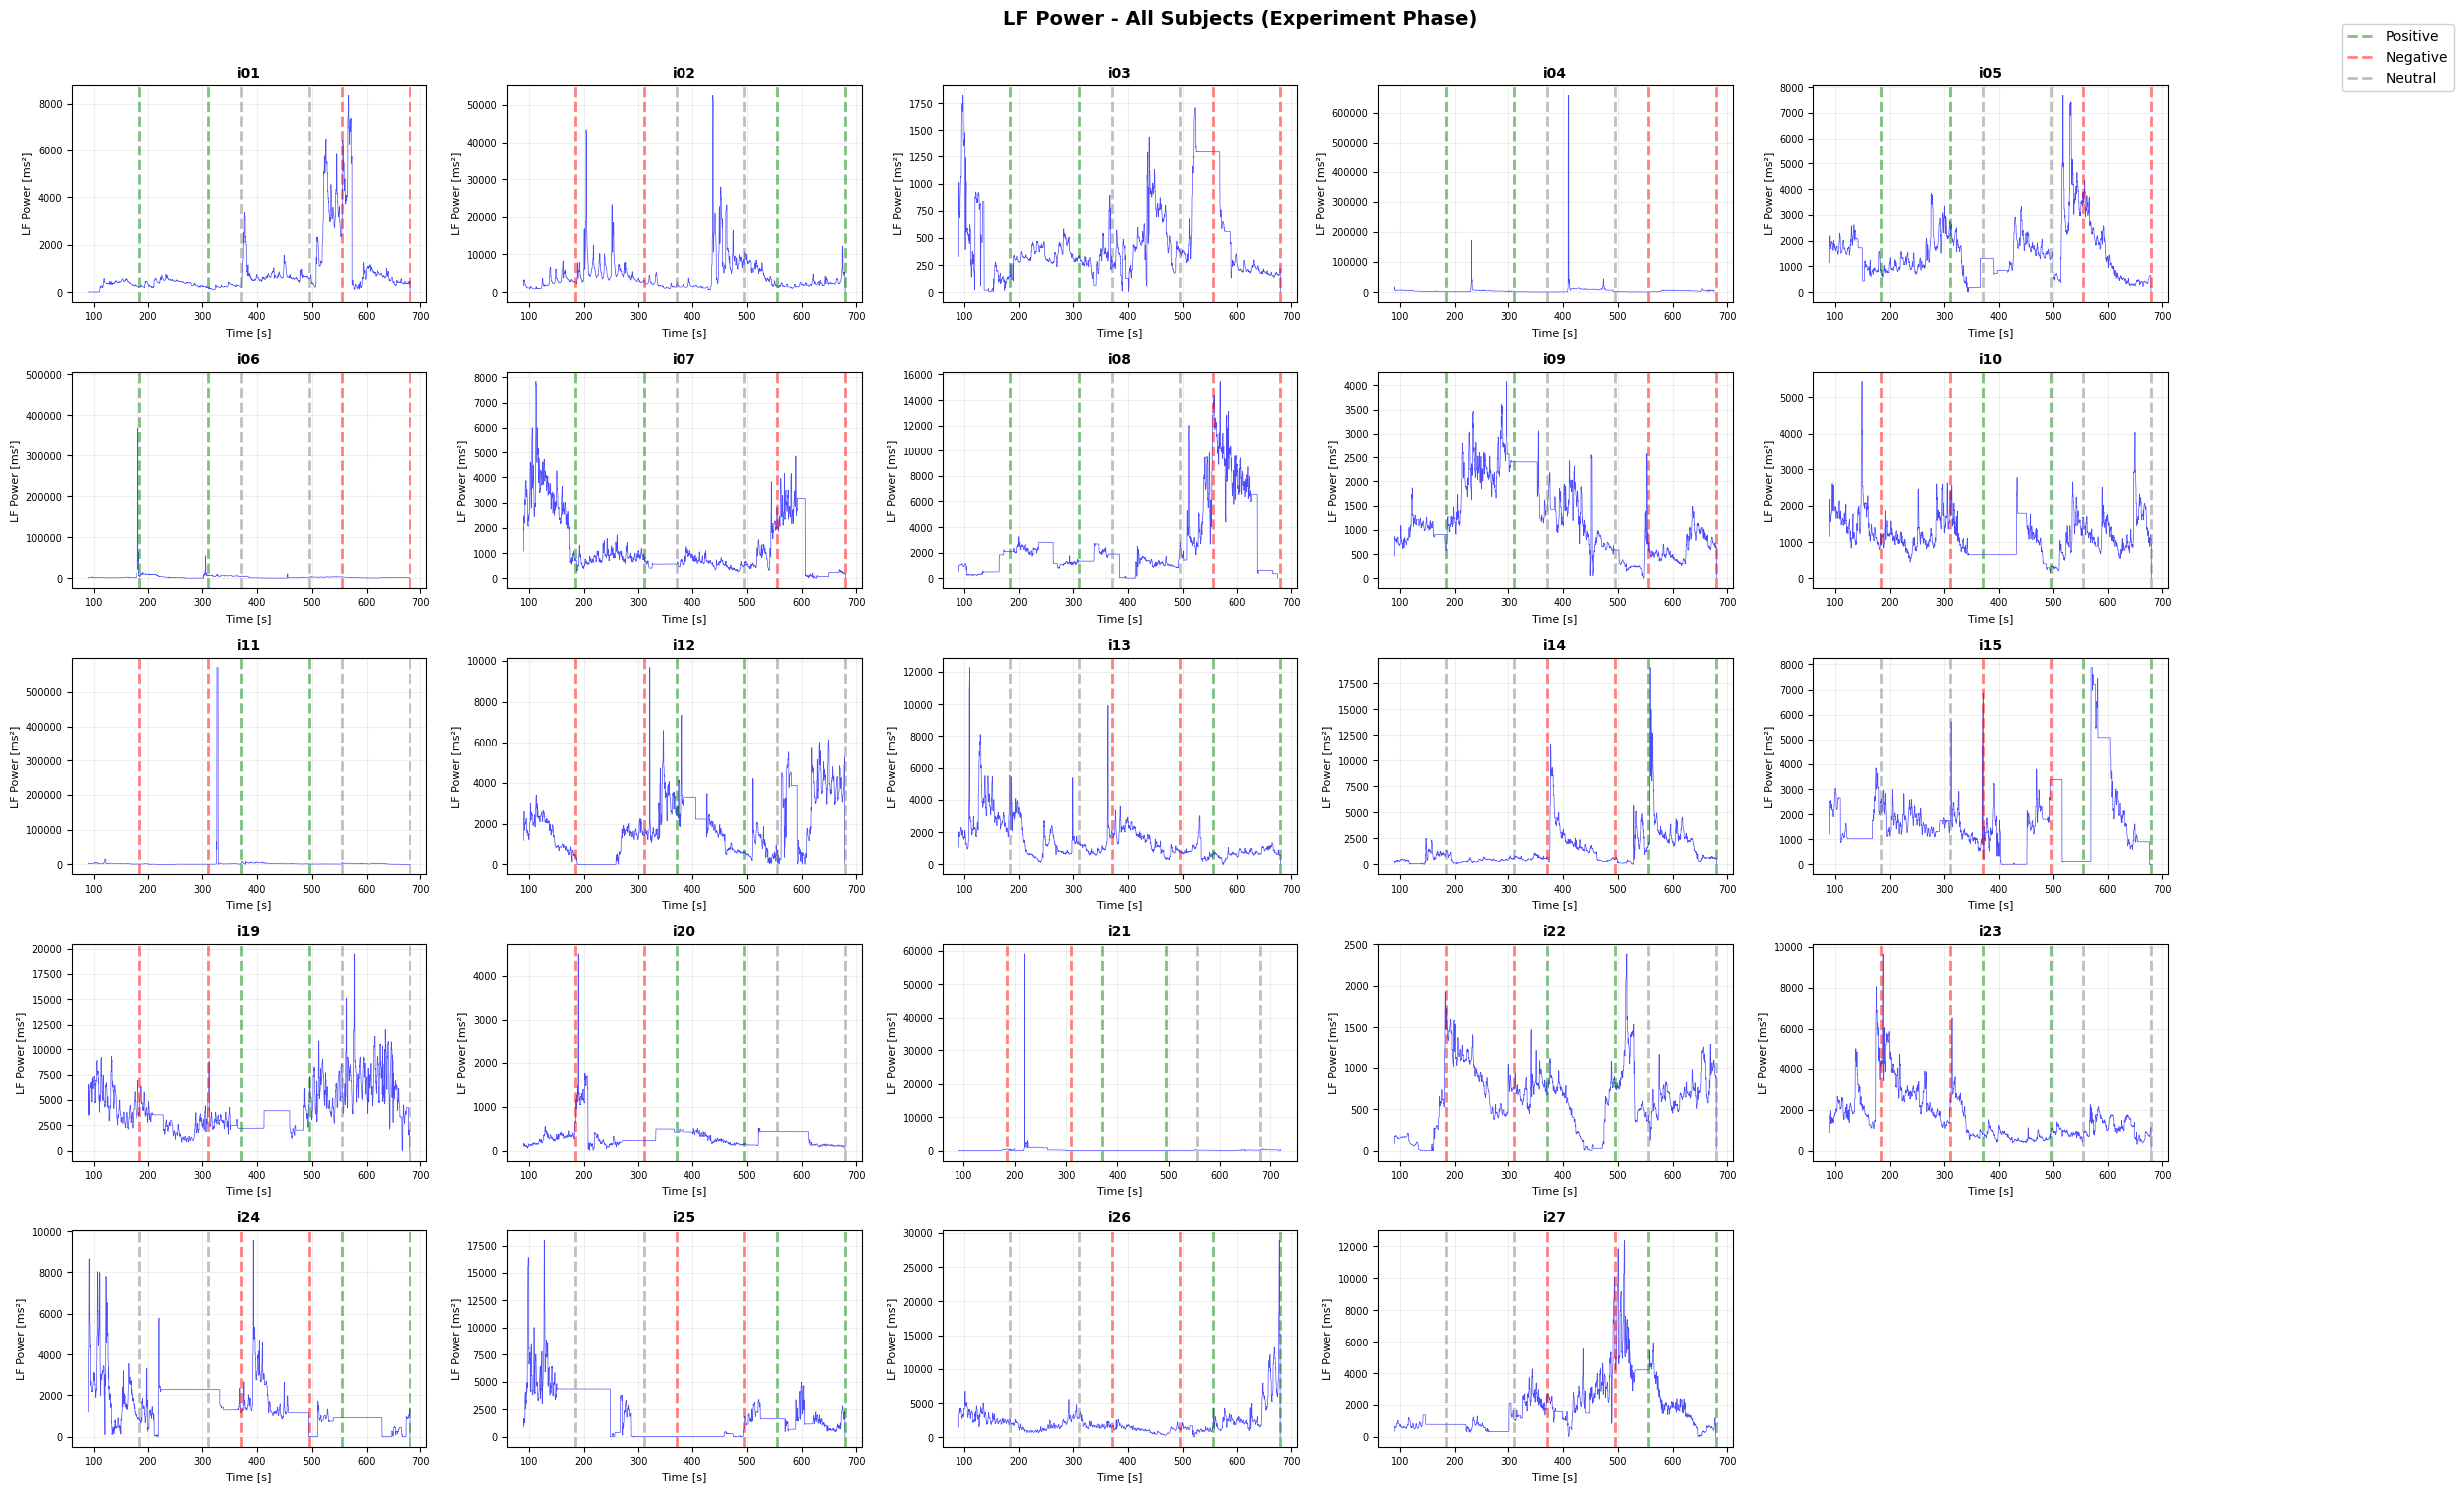

4. Plotting HF Power...


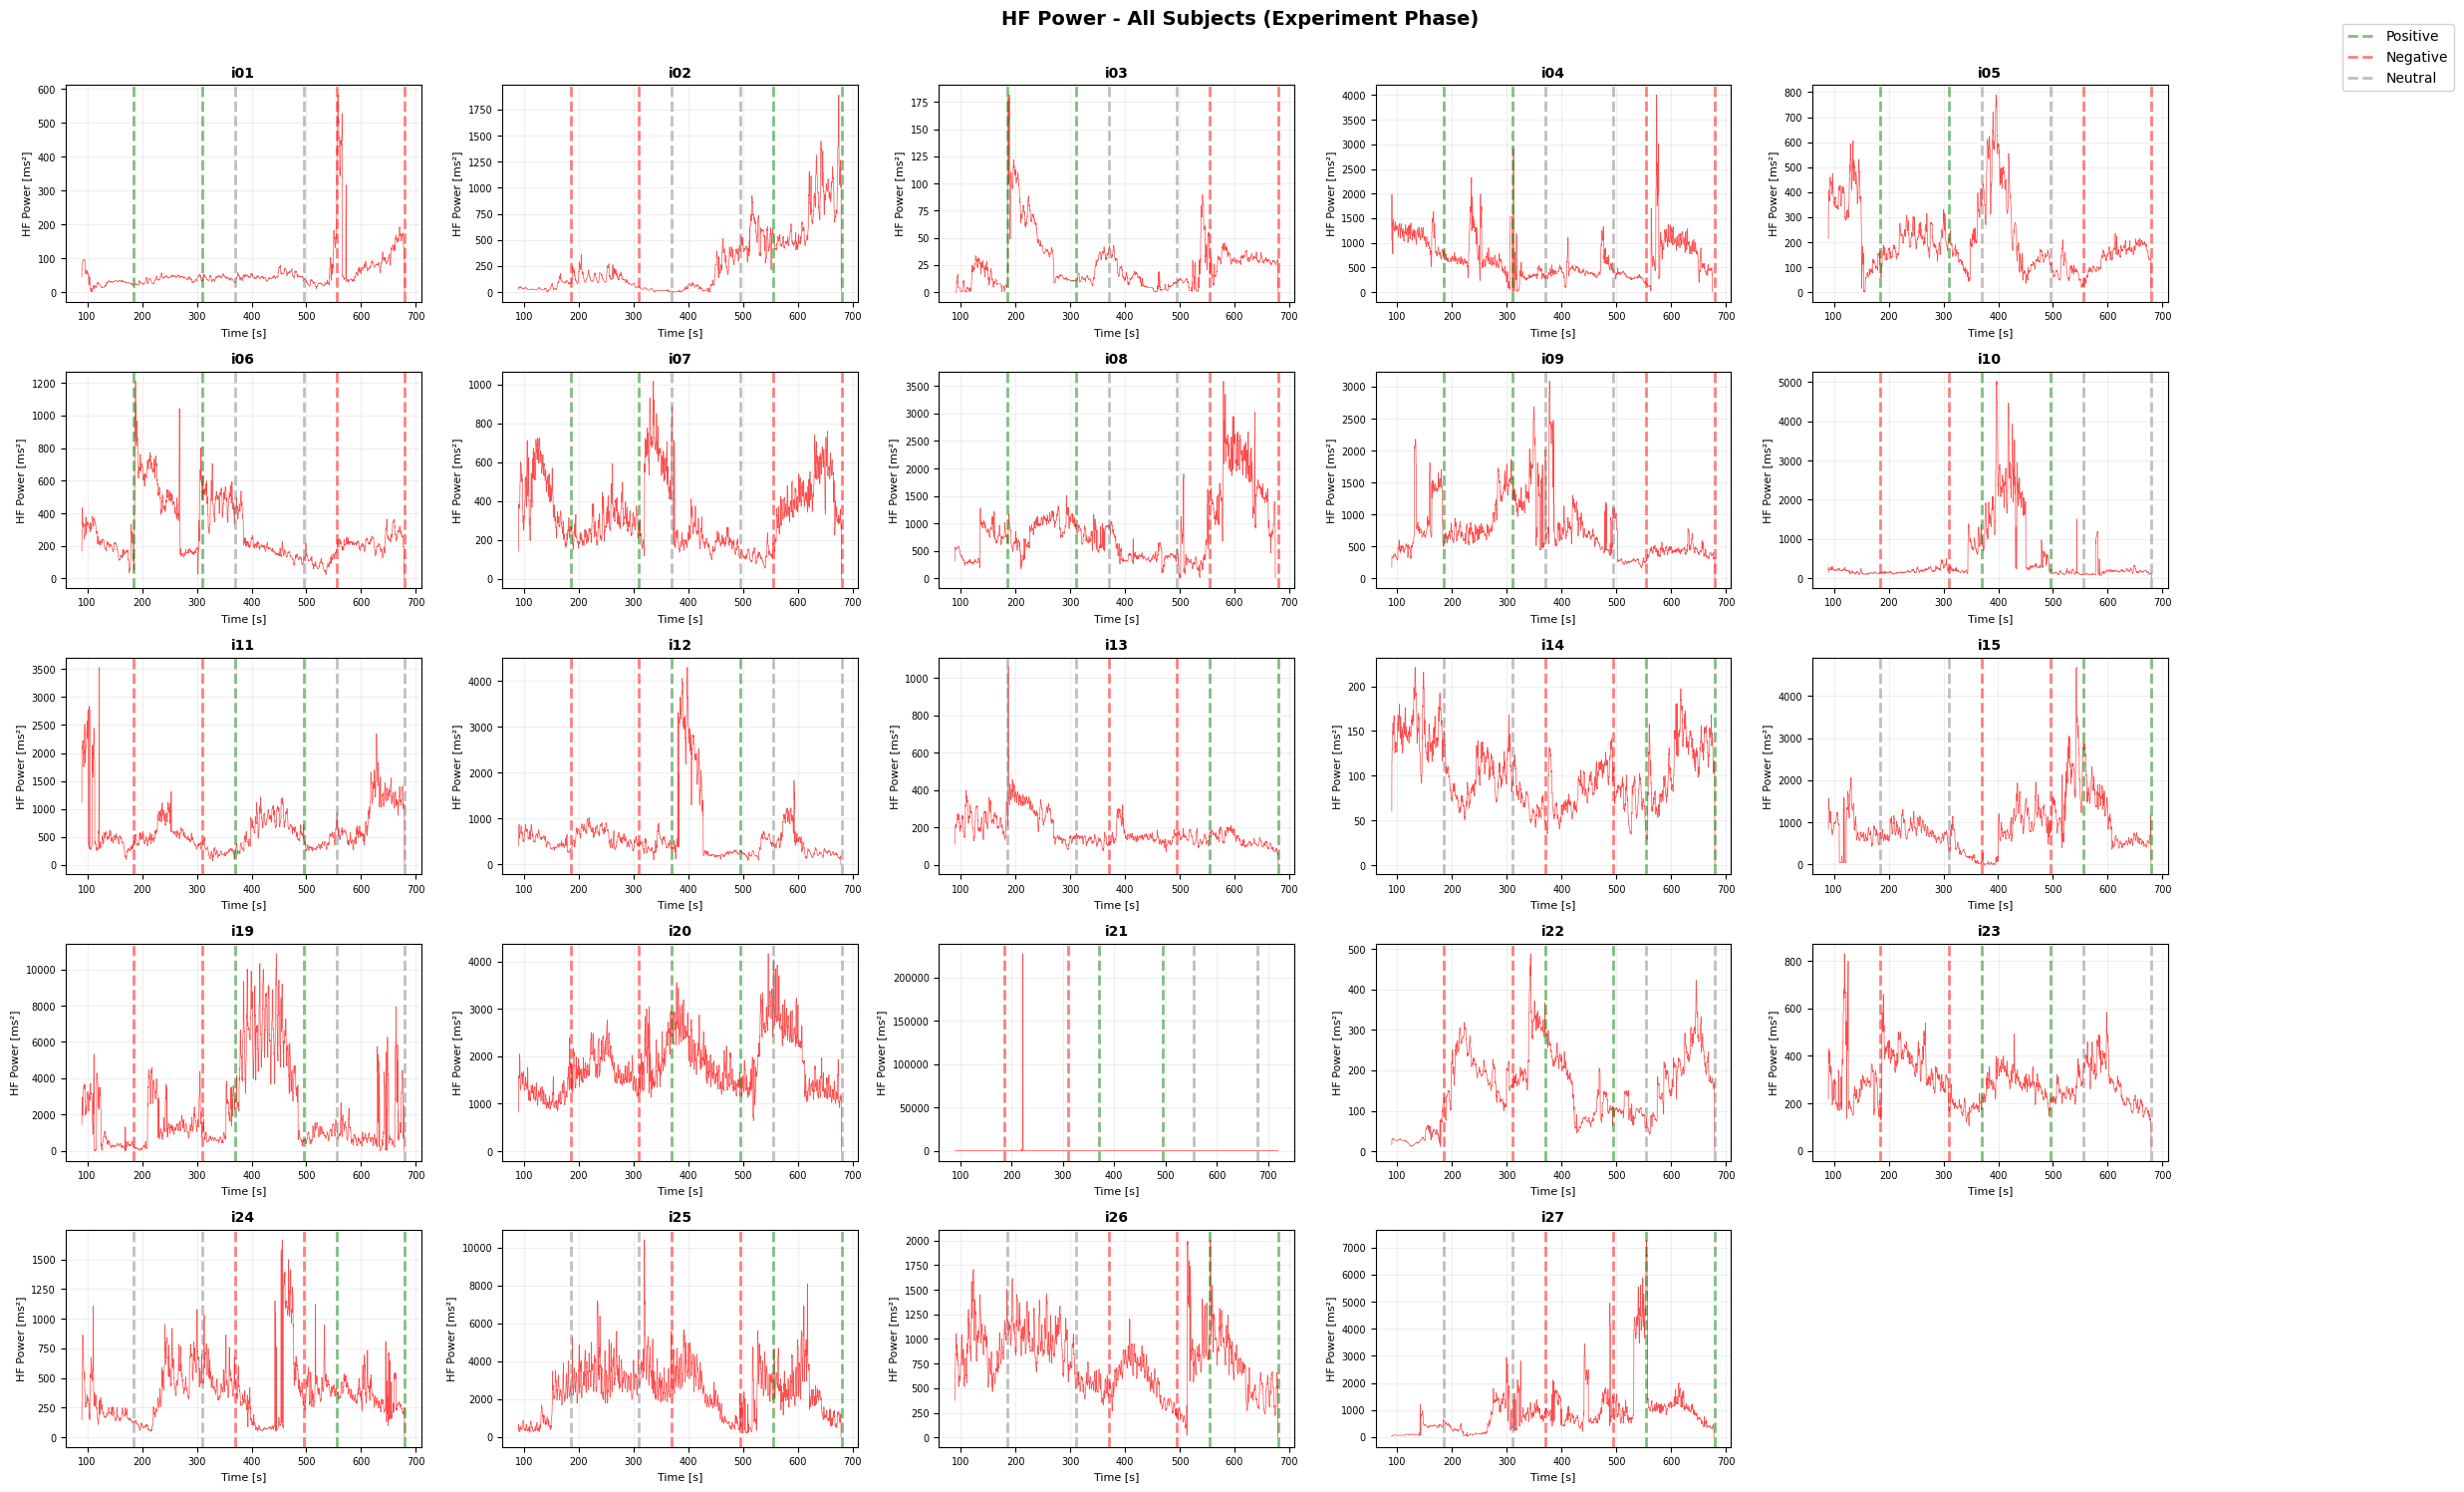

5. Plotting LF/HF Ratio...


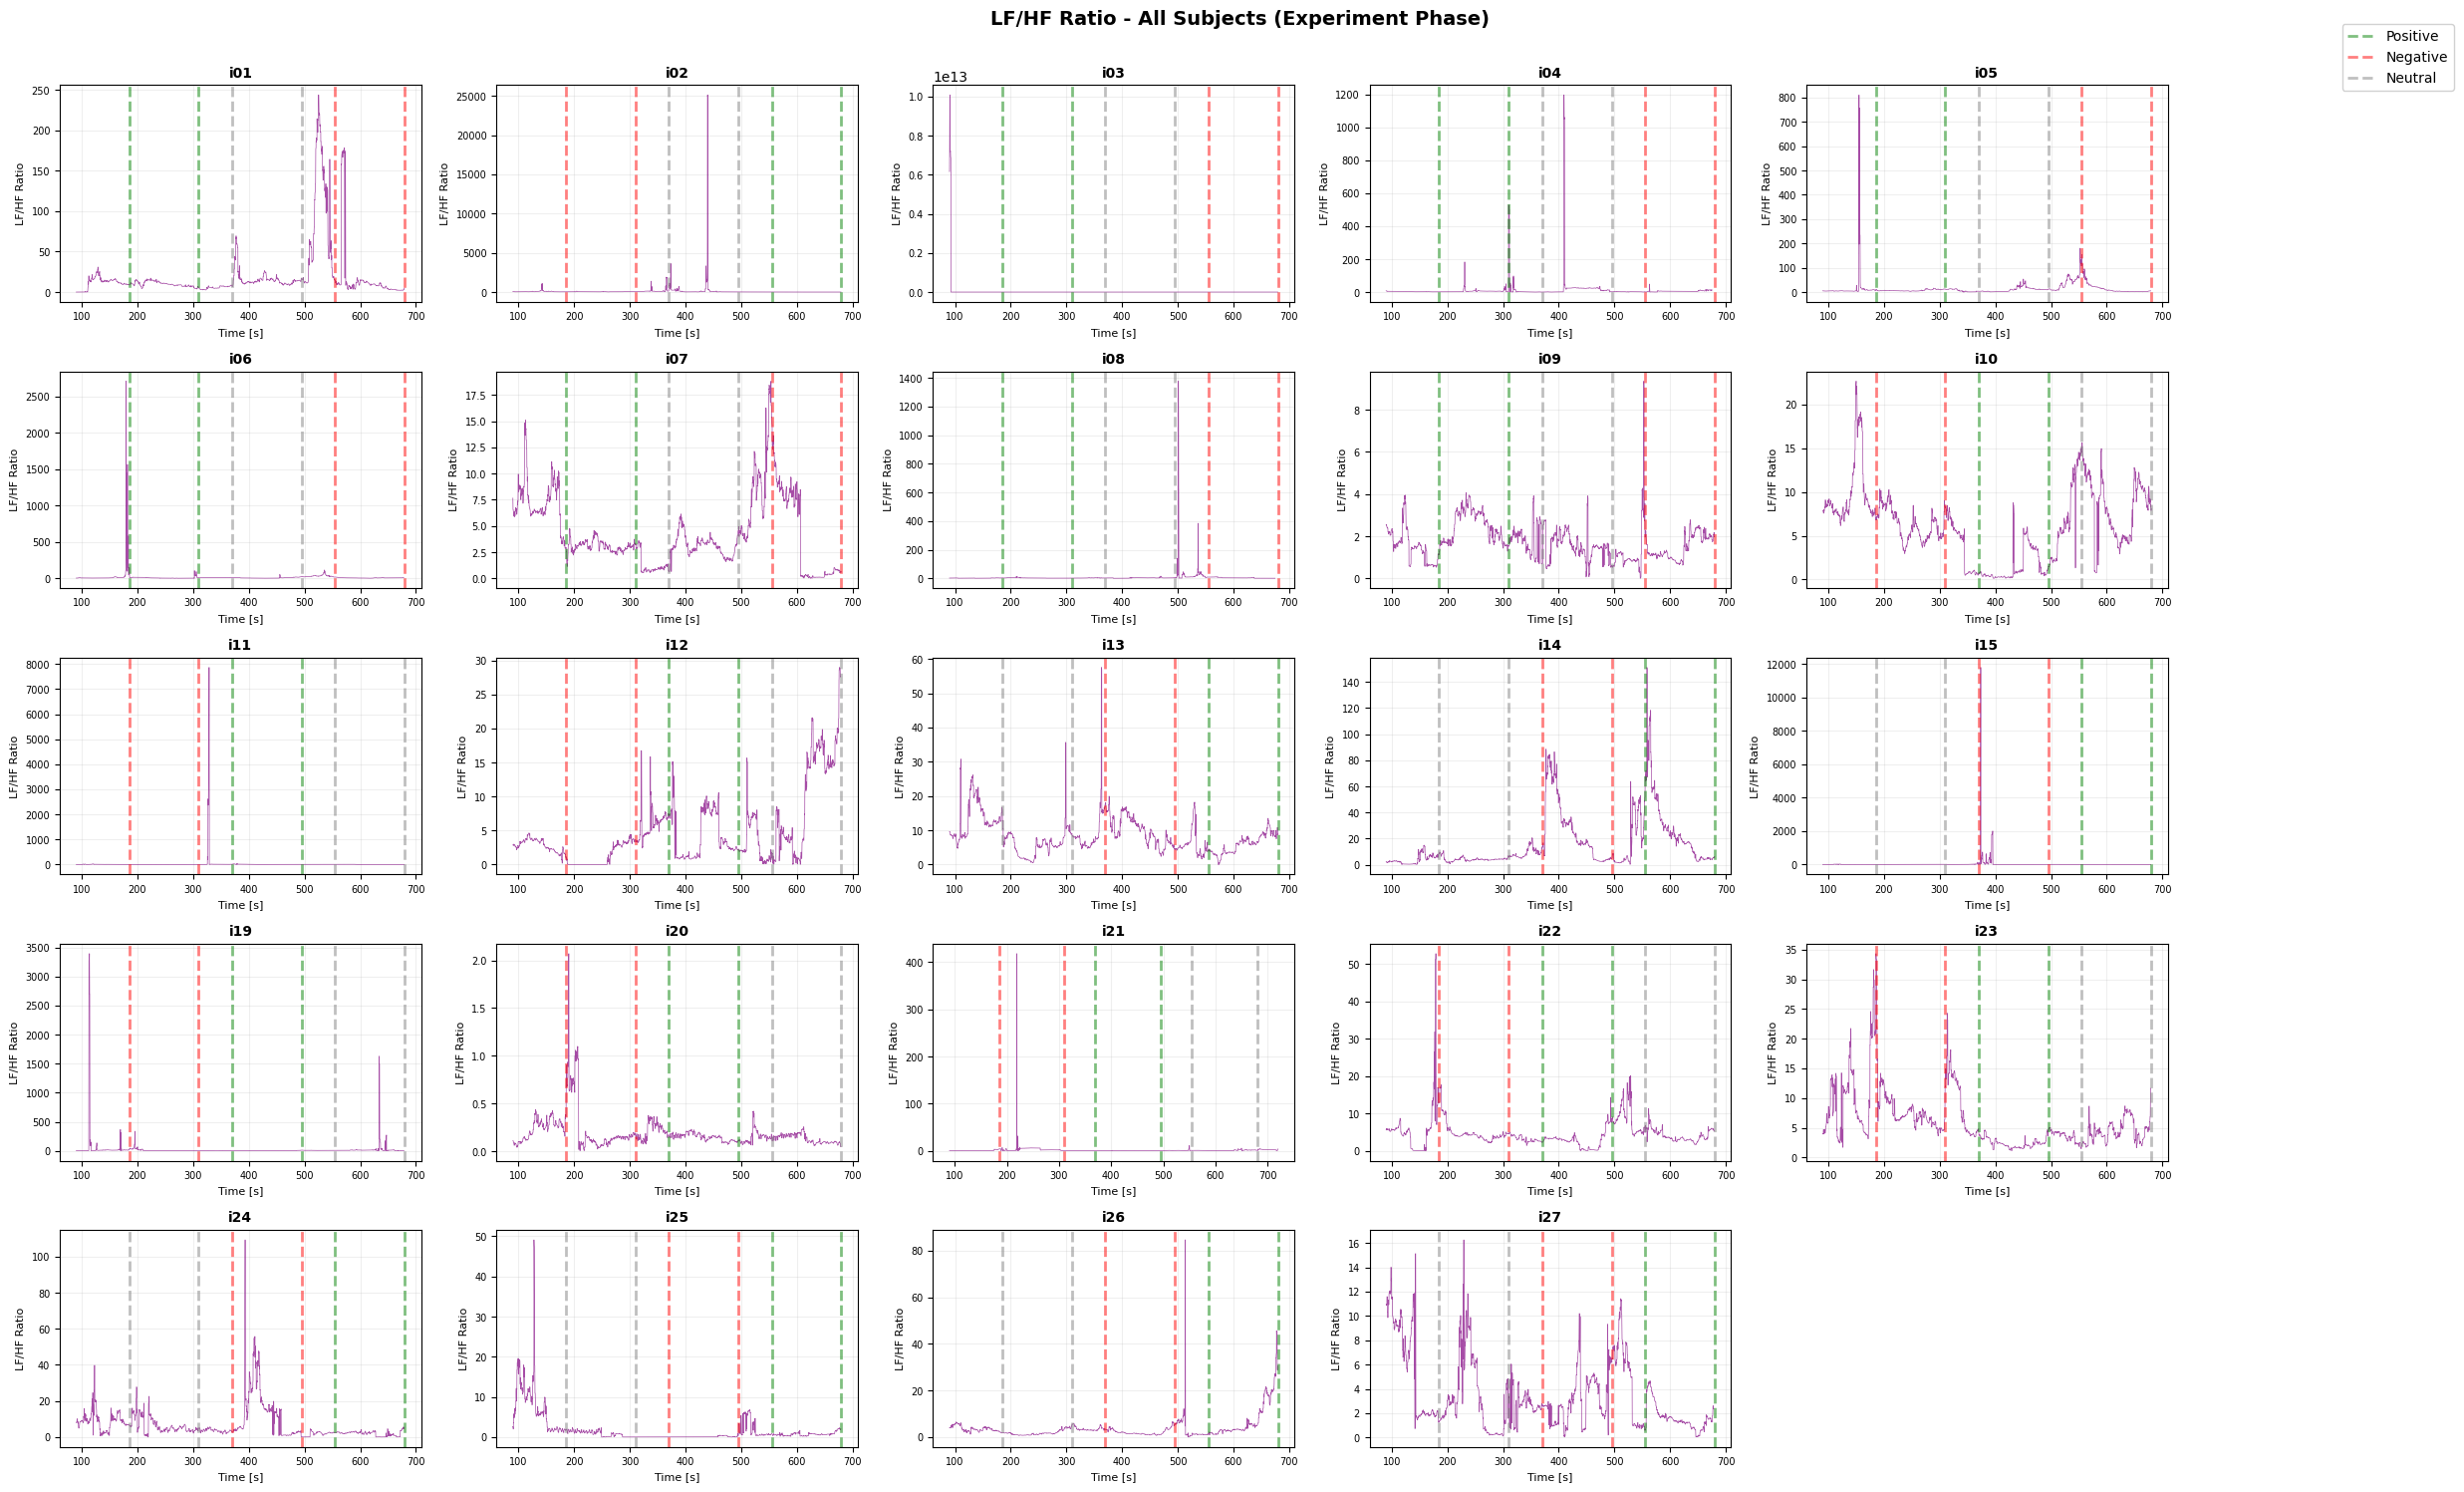

6. Plotting KS goodness-of-fit...


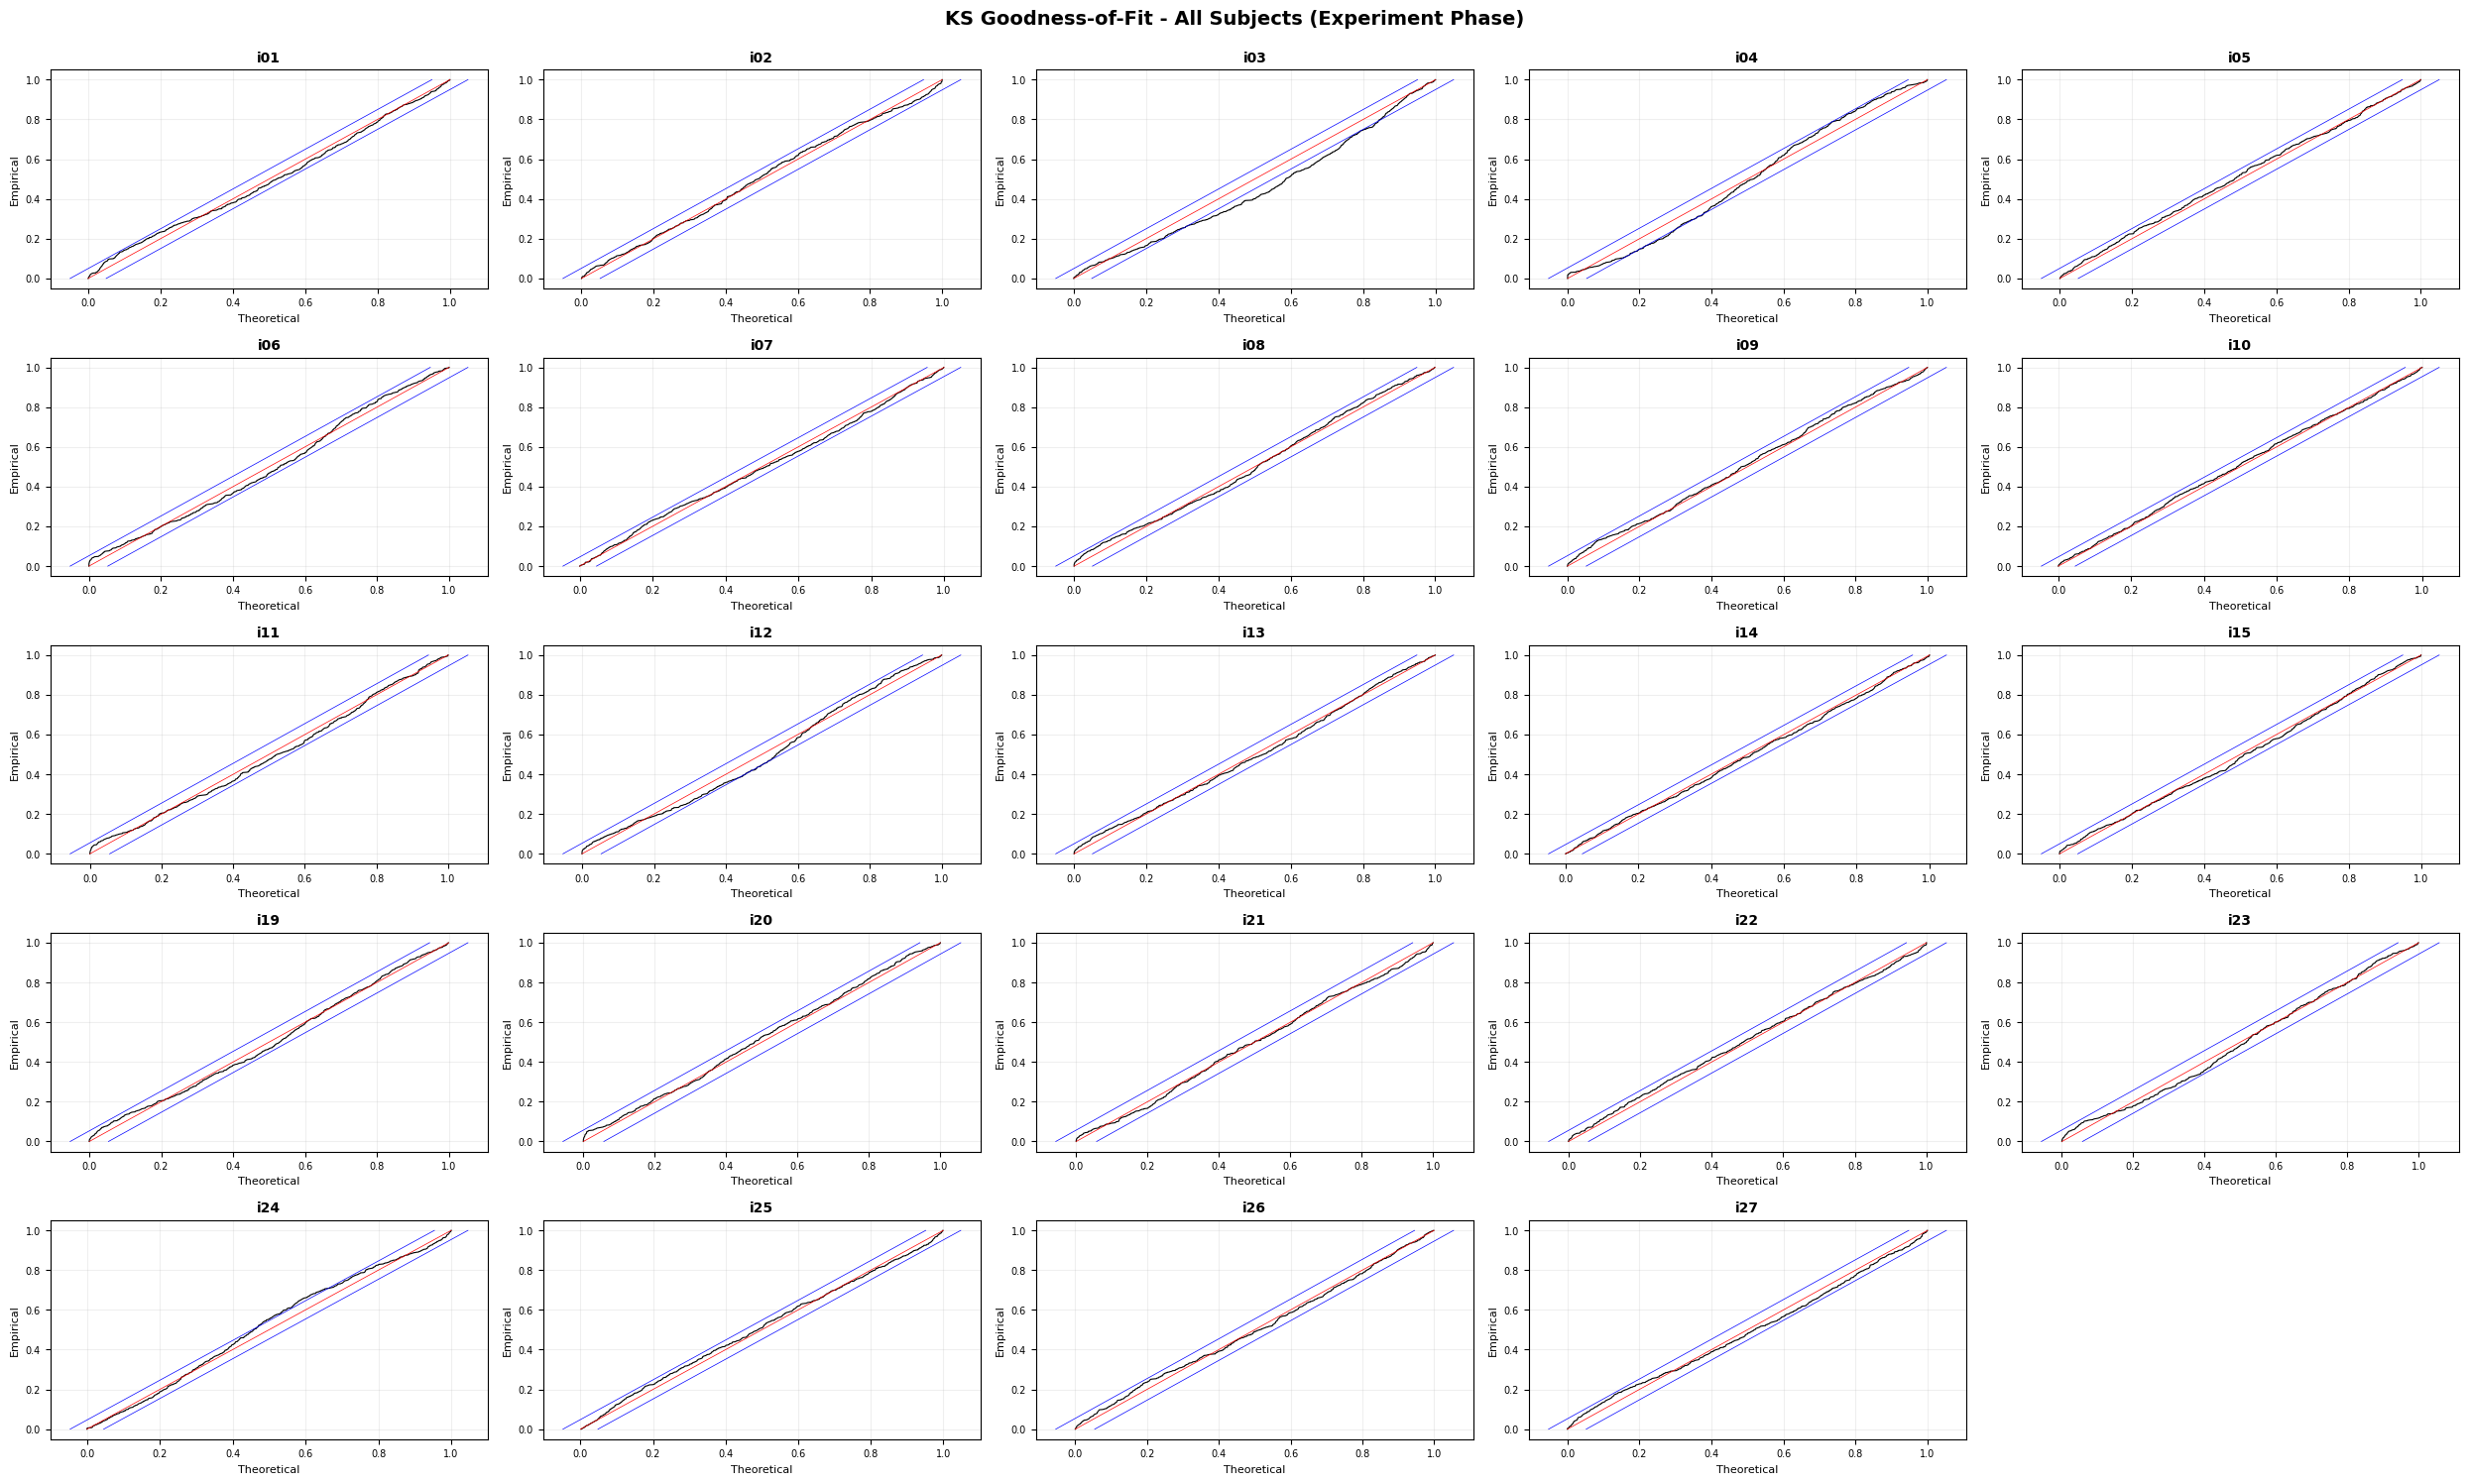


✓ All visualizations complete!


In [9]:
hrv_results = {}
for subject_id, subject in all_subjects.items():
    try:
        # Get RR times for both phases
        baseline_rr_raw = subject.get_rr_timestamps(BASELINE_PHASE).flatten()
        experiment_rr_raw = subject.get_rr_timestamps(EXPERIMENT_PHASE).flatten()
        
        # Stitch together: baseline followed by experiment
        rr_times_full, stitch_info = stitch_rr_phases(baseline_rr_raw, experiment_rr_raw)

        # Preprocess the stitched RR series
        rr_times_clean, clean_info = preprocess_rr(rr_times=rr_times_full, high_rri=1500)
        
        # Compute HRV with spectral indices on the full stitched and cleaned series
        result = compute_full_regression(
            events=rr_times_clean,
            window_length=90.0,
            delta=0.005,
            ar_order=7,
            has_theta0=True,
            right_censoring=True,
            alpha=0.01,
            distribution=Distributions.InverseGaussian,
            max_iter=1000
        )
        result.compute_hrv_indices()
        
        # Store results
        hrv_results[subject_id] = {
            'rr_times': rr_times_clean,
            'hrv_dict': result.to_dict(),
            'taus': result.taus,
            'rr_info': stitch_info,  # Store for later reference
            'clean_info': clean_info  # Store preprocessing info
        }

        
    except Exception as e:
        hrv_results[subject_id] = None
        print(f"  ✗ {subject_id}: {e}")

plot_all_hrv_summaries(hrv_results, all_subjects, video_time_shift=185.0)

#### 2.1.3 Define "Extreme" Events

"Extreme" events are defined as windows containting prominent surges or drops in HF power exceeding ±2 standard deviations from the mean.
1. Extract HF power
2. Smooth HF power using gaussian filter
3. Split data into windows of 10 seconds with 95% overlap
4. Identify windows where value changes exceed ±2σ from mean
5. Label windows as "SURGE", "DROP"

In [10]:
from src.utils import detect_extreme_events_gradient_peaks

extreme_events = detect_extreme_events_gradient_peaks(hrv_results, window_seconds=10, buffer_seconds=20, overlap_ratio=0.95, valid_subjects=all_subjects)

Plot HF power with extreme event markings for all subjects

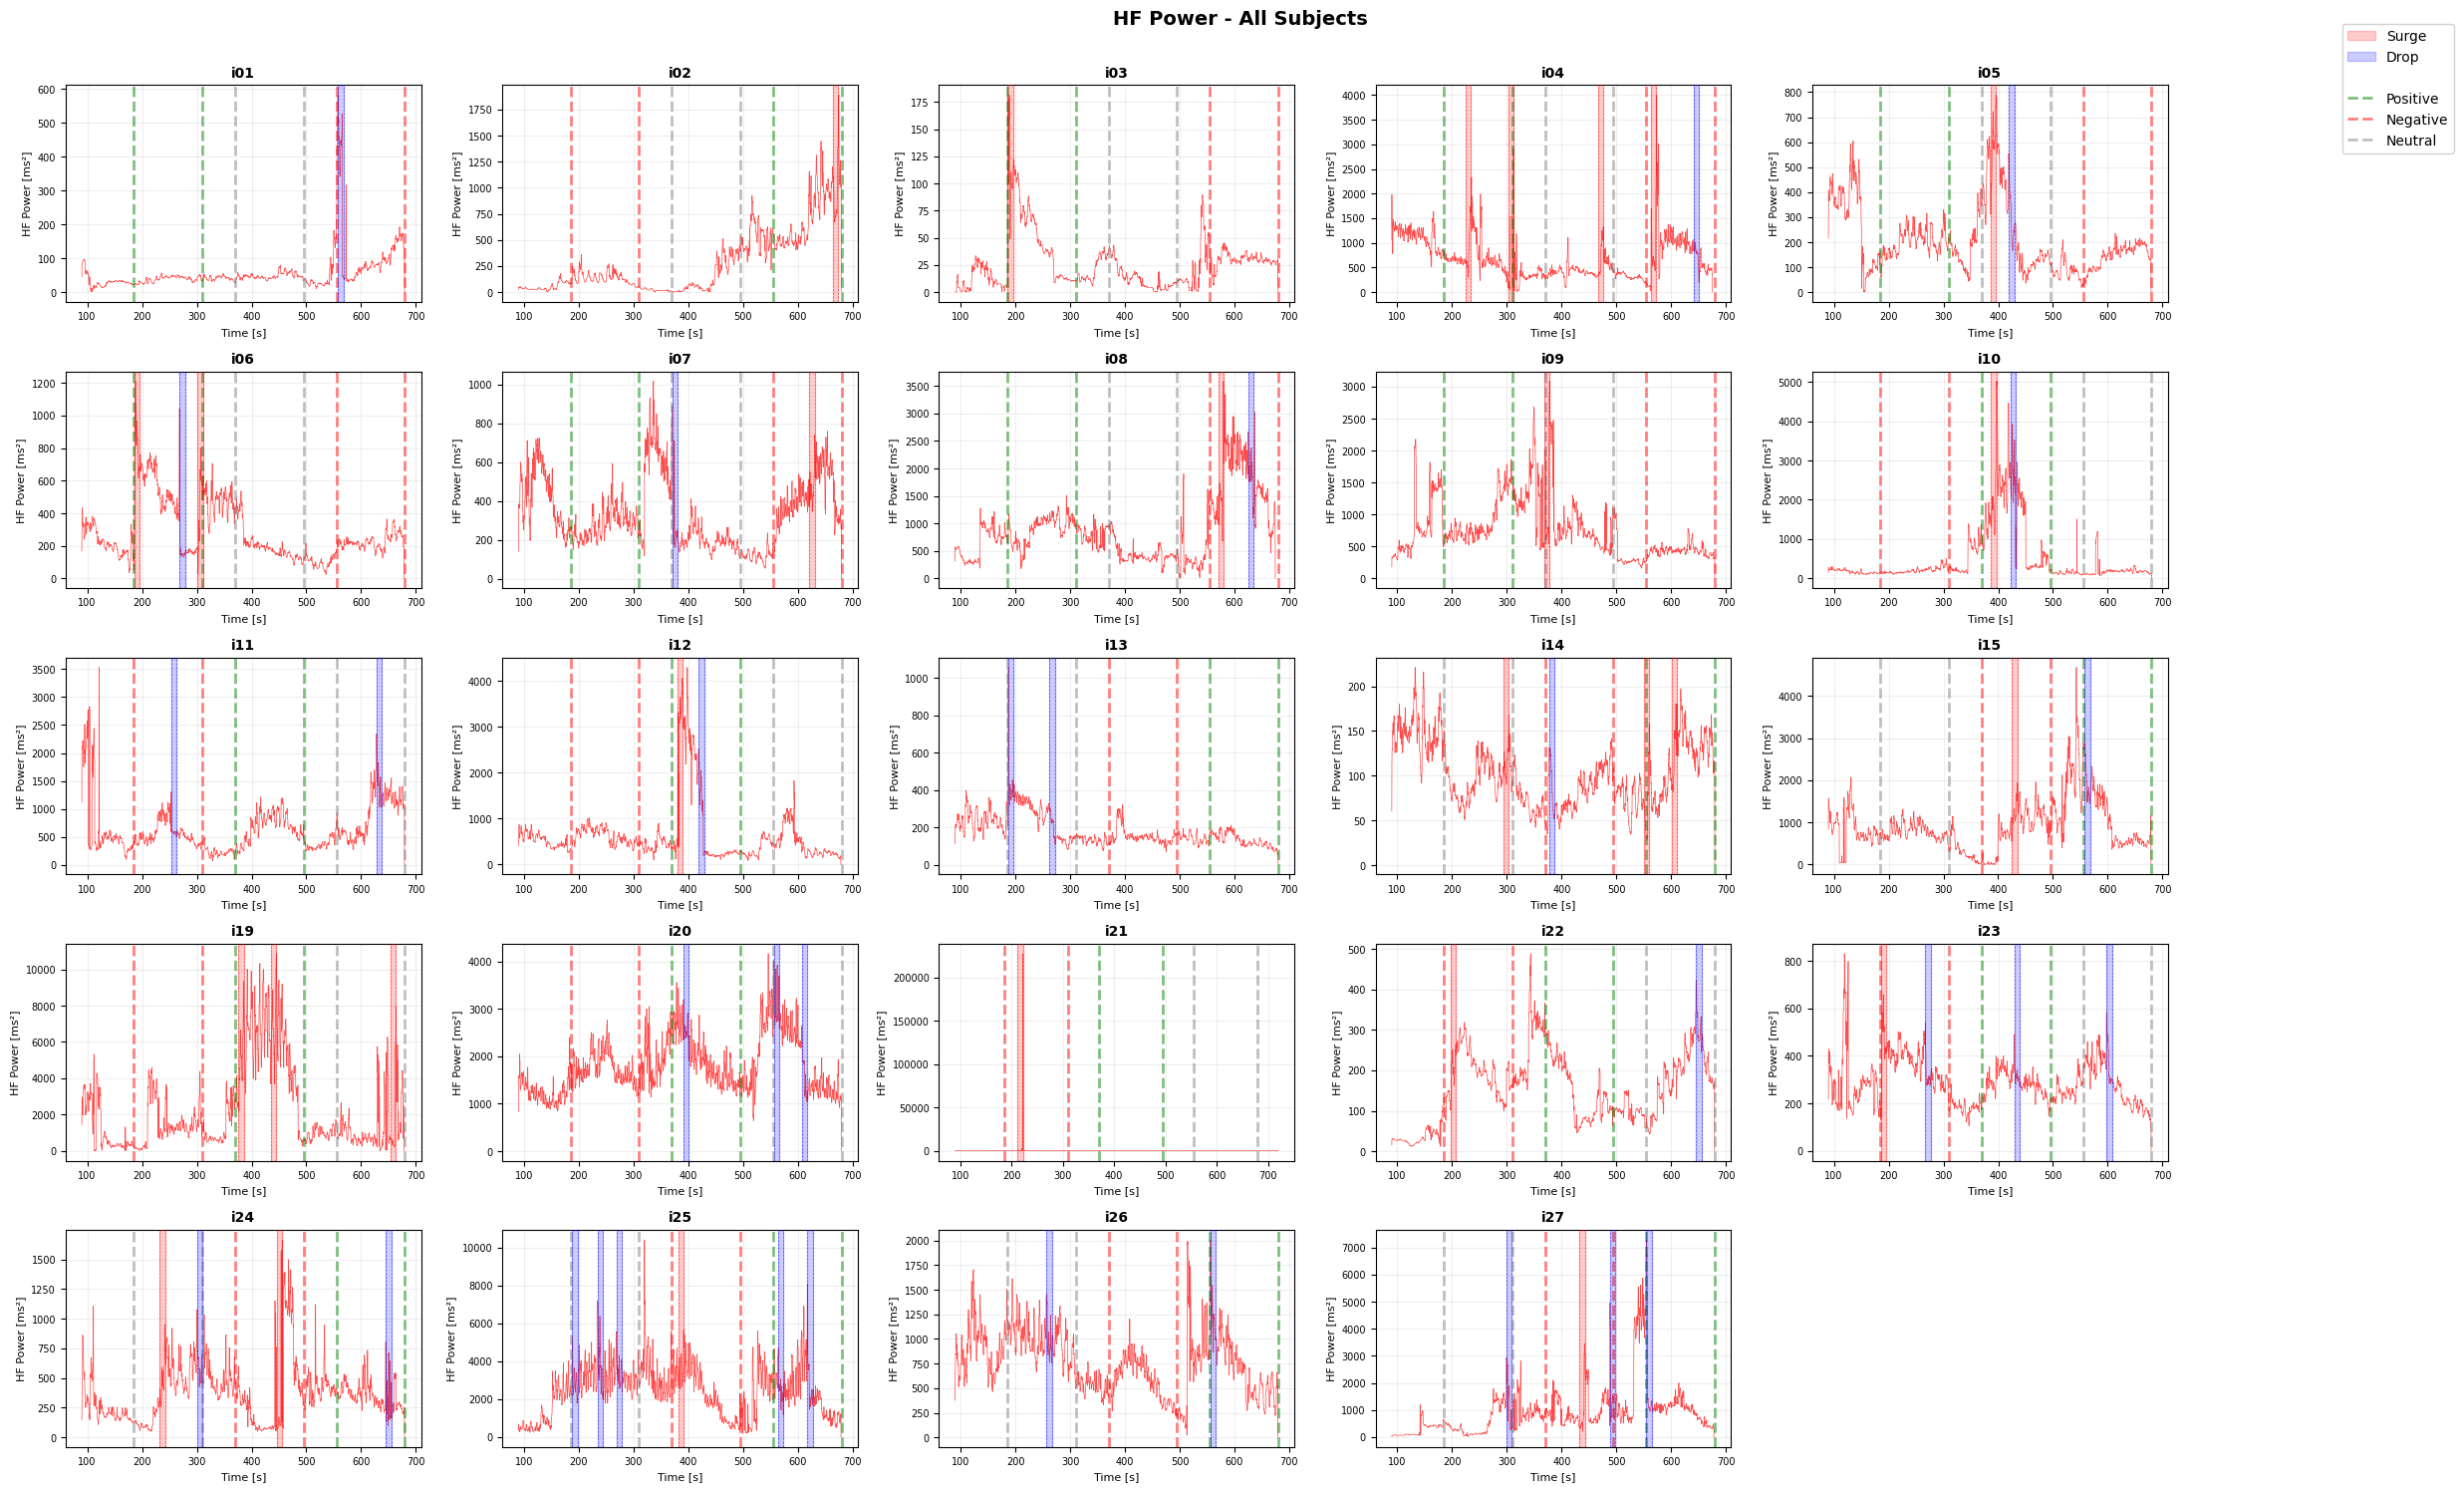

In [8]:
plot_lfhf_power_grid(hrv_results, all_subjects, metric='HF', video_time_shift=185.0, extreme_masks=extreme_events);

### 2.2 Brain Dynamics

#### 2.2.1 BHI Estimation Using SDG Model

Compute BHI using SDGM_LFHF on all subjects with available data and save results. [Computation time is in the hours, done once and results saved for later use]

In [ ]:
# Batch process BHI for all subjects
import time
from pathlib import Path

# Results dictionary
all_bhi_results = {}

# Ensure MATLAB engine is running
print("Starting MATLAB engine...")
eng = matlab.engine.start_matlab()
eng.addpath(str(Path('./BHI_SDG').resolve()), nargout=0)

print(f"\n{'='*70}")
print("Computing BHI for all subjects")
print(f"{'='*70}\n")

for subject_id in all_subjects.keys():
    
    try:
        
        # Compute BHI with FS_bhi=2, TV=1
        eng.eval(f"""
            load('data/{subject_id}/{subject_id}_EMO.mat');
            freq_bands = [4 8; 8 12; 12 30];
            
            % Run BHI
            SDGM_LFHF(EEG_ph{{1}}, freq_bands, RR_ph{{1}}, RRi_ph{{1}}, T_RRi_ph{{1}}, ...
                      4, 2, 1, 'results/bhi/baseline/{subject_id}_bhi_baseline.mat');
            SDGM_LFHF(EEG_ph{{2}}, freq_bands, RR_ph{{2}}, RRi_ph{{2}}, T_RRi_ph{{2}}, ...
                      4, 2, 1, 'results/bhi/experiment/{subject_id}_bhi.mat');
        """, nargout=0)
        
    except Exception as e:
        print(f"  ✗ {subject_id}: {str(e)[:100]}")
        all_bhi_results[subject_id] = None

#### 2.2.2 Create BHI Epochs DataFrame Around Extreme Events

In [11]:
from src.bhi_dataframe import create_bhi_dataframe

# Create BHI epochs dataframe
bhi_df = create_bhi_dataframe(extreme_events, all_subjects, padding_seconds=0
)

# Display summary
print("\nDataFrame shape:", bhi_df.shape)
print("\nFirst few rows:")
print(bhi_df[['id', 'direction', 'eeg_band', 'hrv_band', 'channel_label', 
              'event_type', 'emotion', 'mean', 'median']].head(20))

# Check event type distribution
print("\nEvent type distribution:")
print(bhi_df.groupby(['event_type', 'emotion']).size())

Processing i01...
Processing i02...
Processing i03...
Processing i04...
Processing i05...
Processing i06...
Processing i07...
Processing i08...
Processing i09...
Processing i10...
Processing i11...
Processing i12...
Processing i13...
Processing i14...
Processing i15...
Processing i19...
Processing i20...
Processing i21...
Processing i22...
Processing i23...
Processing i24...
Processing i25...
Processing i26...
Processing i27...

DataFrame shape: (32300, 13)

First few rows:
     id direction eeg_band hrv_band channel_label event_type emotion  \
0   i01       BtH    delta       lf            P8       DROP     NEG   
1   i01       BtH    delta       lf            T8       DROP     NEG   
2   i01       BtH    delta       lf            F8       DROP     NEG   
3   i01       BtH    delta       lf            F4       DROP     NEG   
4   i01       BtH    delta       lf            C4       DROP     NEG   
5   i01       BtH    delta       lf            P4       DROP     NEG   
6   i01       BtH

In [12]:
bhi_df

id direction eeg_band hrv_band  \
0      i01       BtH    delta       lf   
1      i01       BtH    delta       lf   
2      i01       BtH    delta       lf   
3      i01       BtH    delta       lf   
4      i01       BtH    delta       lf   
...    ...       ...      ...      ...   
32295  i27       HtB    gamma       hf   
32296  i27       HtB    gamma       hf   
32297  i27       HtB    gamma       hf   
32298  i27       HtB    gamma       hf   
32299  i27       HtB    gamma       hf   

                                                 channel channel_label  \
0      [[P8], [], [[126]], [[0.5111111111111111]], [[...            P8   
1      [[T8], [], [[90]], [[0.5111111111111111]], [[6...            T8   
2      [[F8], [], [[54]], [[0.5111111111111111]], [[0...            F8   
3      [[F4], [], [[39]], [[0.33333333333333337]], [[...            F4   
4      [[C4], [], [[90]], [[0.25555555555555554]], [[...            C4   
...                                                  ...           ...   
32295  [[C3], [], [[-90]], [[0.25555555555555554]], [...            C3   
32296  [[F3], [], [[-39]], [[0.33333333333333337]], [...            F3   
32297  [[F7], [], [[-54]], [[0.5111111111111111]], [[...            F7   
32298  [[T7], [], [[-90]], [[0.5111111111111111]], [[...            T7   
32299  [[P7], [], [[-126]], [[0.5111111111111111]], [...            P7   

      event_type emotion                                               data  \
0           DROP     NEG  [510.50966468691416, 560.8742568601731, 602.72...   
1           DROP     NEG  [36.85299420475789, 46.581399007088635, 59.206...   
2           DROP     NEG  [6.707584224480768, 7.689831047981129, 9.97395...   
3           DROP     NEG  [15.52262339494851, 16.766821537032072, 18.236...   
4           DROP     NEG  [42.5128722646324, 50.76420704947627, 59.04443...   
...          ...     ...                                                ...   
32295         BL    None  [1.0612653352316384, 0.9859369875214216, 1.035...   
32296         BL    None  [0.6038056696629073, 0.6118245686019457, 0.678...   
32297         BL    None  [0.7338824314048485, 0.7333197216145458, 0.787...   
32298         BL    None  [0.6703585168436356, 0.650532346164784, 0.6321...   
32299         BL    None  [1.061170049716586, 0.9969358612809969, 0.8772...   

              mean       median  \
0      2398.918173  2082.026425   
1       147.019084   154.795448   
2        44.994556    33.939356   
3        34.827378    30.722180   
4       118.393493   112.332598   
...            ...          ...   
32295     1.593881     1.472762   
32296     0.985175     0.911954   
32297     0.939719     0.910635   
32298     0.621637     0.609045   
32299     0.602511     0.594752   

                                                  z_data  z_median  
0      [-1.2135718895300402, -1.181205453445494, -1.1... -0.203648  
1      [-1.795146617795651, -1.6366231290137425, -1.4...  0.126715  
2      [-1.201231365727823, -1.1704139454290259, -1.0... -0.346850  
3      [-1.3421945448785535, -1.2556896422196082, -1.... -0.285421  
4      [-1.71137769033588, -1.5252807640754626, -1.33... -0.136695  
...                                                  ...       ...  
32295  [-0.6820238419268415, -0.7784831934404026, -0.... -0.155095  
32296  [-0.752438005718974, -0.7366167890680979, -0.6... -0.144464  
32297  [-0.4097913784159715, -0.41091165113904815, -0... -0.057904  
32298  [0.18030411045058584, 0.10693264478617706, 0.0... -0.046603  
32299  [1.3846457262923457, 1.1907289914493269, 0.829... -0.023426  

[32300 rows x 13 columns]

#### 2.2.3 Statistical Analysis of BHI Dynamics Around Extreme Events

Friedman test with Wilcoxon post-hoc analysis to compare BHI dynamics across three event types: baseline (BL), surge (SURGE), and drop (DROP).

In [13]:
# -------------------------------
# FRIEDMAN TEST WITH WILCOXON POST-HOC
# -------------------------------
friedman_results = []

for direction in bhi_df['direction'].unique():
    for eeg_band in bhi_df['eeg_band'].unique():
        for hrv_band in bhi_df['hrv_band'].unique():
            for channel in bhi_df['channel_label'].unique():

                # Select data for this combination
                sub_df = bhi_df[
                    (bhi_df.direction == direction) &
                    (bhi_df.eeg_band == eeg_band) &
                    (bhi_df.hrv_band == hrv_band) &
                    (bhi_df.channel_label == channel)
                ]

                # Get median z_median per subject for each event type
                bl_data = sub_df[sub_df.event_type == 'BL'].groupby('id')['median'].median()
                surge_data = sub_df[sub_df.event_type == 'SURGE'].groupby('id')['median'].median()
                drop_data = sub_df[sub_df.event_type == 'DROP'].groupby('id')['median'].median()

                # Find common subjects across all three conditions
                common_ids = bl_data.index.intersection(surge_data.index).intersection(drop_data.index)

                # Align data
                bl = bl_data.loc[common_ids].values
                surge = surge_data.loc[common_ids].values
                drop = drop_data.loc[common_ids].values

                # Friedman test across 3 conditions (BL, SURGE, DROP)
                friedman_stat, friedman_p = friedmanchisquare(bl, surge, drop)

                # Post-hoc pairwise Wilcoxon tests (if Friedman is significant)
                posthoc_results = {}
                if friedman_p < 0.05:
                    # BL vs SURGE
                    w_stat_bl_surge, p_bl_surge = wilcoxon(bl, surge)
                    posthoc_results['BL_vs_SURGE'] = {'stat': w_stat_bl_surge, 'p': p_bl_surge}

                    # BL vs DROP
                    w_stat_bl_drop, p_bl_drop = wilcoxon(bl, drop)
                    posthoc_results['BL_vs_DROP'] = {'stat': w_stat_bl_drop, 'p': p_bl_drop}

                    # SURGE vs DROP
                    w_stat_surge_drop, p_surge_drop = wilcoxon(surge, drop)
                    posthoc_results['SURGE_vs_DROP'] = {'stat': w_stat_surge_drop, 'p': p_surge_drop}

                    # Apply Bonferroni correction for 3 comparisons
                    pvals = [p_bl_surge, p_bl_drop, p_surge_drop]
                    rejected, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')

                    posthoc_results['BL_vs_SURGE']['p_corrected'] = pvals_corrected[0]
                    posthoc_results['BL_vs_SURGE']['significant'] = rejected[0]

                    posthoc_results['BL_vs_DROP']['p_corrected'] = pvals_corrected[1]
                    posthoc_results['BL_vs_DROP']['significant'] = rejected[1]

                    posthoc_results['SURGE_vs_DROP']['p_corrected'] = pvals_corrected[2]
                    posthoc_results['SURGE_vs_DROP']['significant'] = rejected[2]

                friedman_results.append({
                    'direction': direction,
                    'eeg_band': eeg_band,
                    'hrv_band': hrv_band,
                    'channel': channel,
                    'n_subjects': len(common_ids),
                    'friedman_stat': friedman_stat,
                    'friedman_p': friedman_p,
                    'significant': friedman_p < 0.05,
                    'posthoc': posthoc_results if friedman_p < 0.05 else None,
                    'significant_posthoc': (posthoc_results['BL_vs_SURGE']['significant'] or posthoc_results['BL_vs_DROP']['significant']) if friedman_p < 0.05 else False,
                })

# Convert to DataFrame
friedman_df = pd.DataFrame(friedman_results)

In [14]:
friedman_df

direction eeg_band hrv_band channel  n_subjects  friedman_stat  \
0         BtH    delta       lf      P8          14      10.428571   
1         BtH    delta       lf      T8          14      10.714286   
2         BtH    delta       lf      F8          14       3.857143   
3         BtH    delta       lf      F4          14       8.142857   
4         BtH    delta       lf      C4          14       7.000000   
..        ...      ...      ...     ...         ...            ...   
375       HtB    gamma       hf      C3          14       6.142857   
376       HtB    gamma       hf      F3          14       1.857143   
377       HtB    gamma       hf      F7          14       5.285714   
378       HtB    gamma       hf      T7          14       3.571429   
379       HtB    gamma       hf      P7          14       5.571429   

     friedman_p  significant  \
0      0.005438         True   
1      0.004714         True   
2      0.145356        False   
3      0.017053         True   
4      0.030197         True   
..          ...          ...   
375    0.046355         True   
376    0.395118        False   
377    0.071158        False   
378    0.167677        False   
379    0.061685        False   

                                               posthoc  significant_posthoc  
0    {'BL_vs_SURGE': {'stat': 31.0, 'p': 0.19372558...                 True  
1    {'BL_vs_SURGE': {'stat': 35.0, 'p': 0.29577636...                 True  
2                                                 None                False  
3    {'BL_vs_SURGE': {'stat': 34.0, 'p': 0.26757812...                 True  
4    {'BL_vs_SURGE': {'stat': 32.0, 'p': 0.21655273...                 True  
..                                                 ...                  ...  
375  {'BL_vs_SURGE': {'stat': 19.0, 'p': 0.03527832...                False  
376                                               None                False  
377                                               None                False  
378                                               None                False  
379                                               None                False  

[380 rows x 10 columns]

Visualize post-hoc significance of the three pairwise comparisons (BL vs SURGE, BL vs DROP, SURGE vs DROP) across time, HRV bands, and EEG bands.

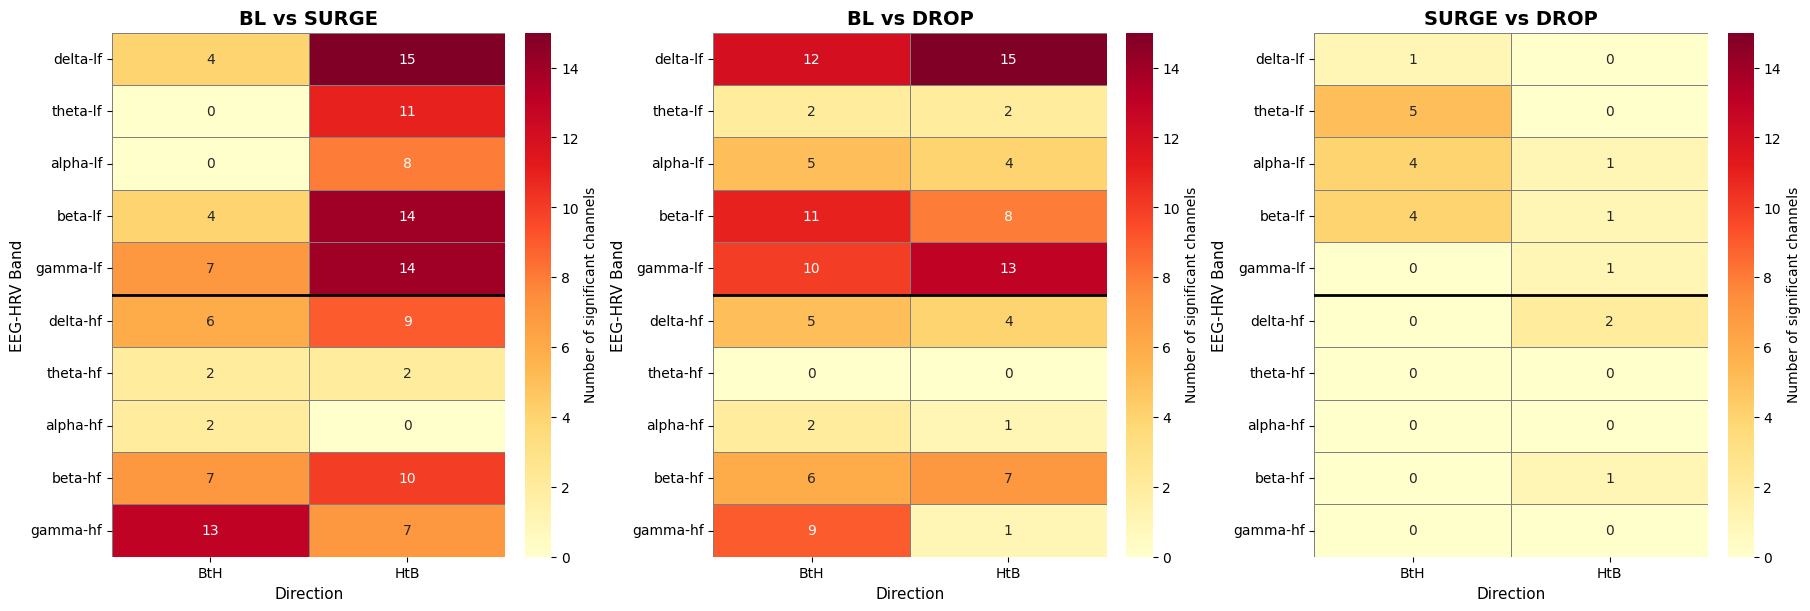

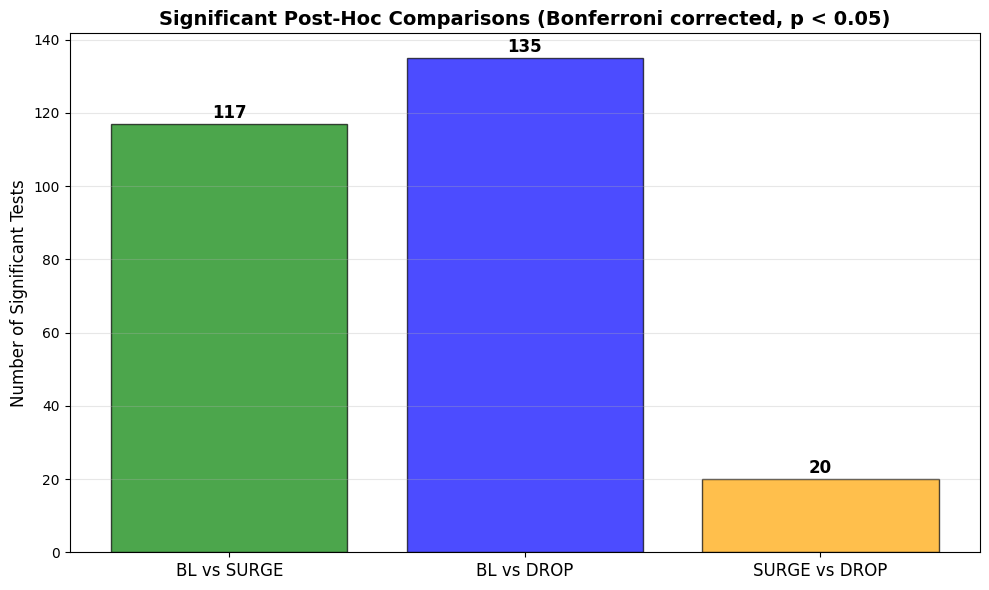

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract post-hoc comparison results for visualization
posthoc_viz_data = []
for _, row in friedman_df.iterrows():
    if row["posthoc"] is not None:
        for comparison, results in row["posthoc"].items():
            posthoc_viz_data.append(
                {
                    "direction": row["direction"],
                    "eeg_band": row["eeg_band"],
                    "hrv_band": row["hrv_band"],
                    "channel": row["channel"],
                    "comparison": comparison,
                    "significant": results["significant"],
                    "p_corrected": results["p_corrected"],
                }
            )

posthoc_df = pd.DataFrame(posthoc_viz_data)

comparisons = ["BL_vs_SURGE", "BL_vs_DROP", "SURGE_vs_DROP"]
titles = ["BL vs SURGE", "BL vs DROP", "SURGE vs DROP"]

# Fixed ordering for axes/index
eeg_bands = ["delta", "theta", "alpha", "beta", "gamma"]
hrv_bands = ["lf", "hf"]
all_band_combos = [f"{eeg}-lf" for eeg in eeg_bands] + [f"{eeg}-hf" for eeg in eeg_bands]

all_directions = bhi_df["direction"].unique()

# --- build all heatmaps first (so we can share the same color scale) ---
heatmaps = {}
for comp in comparisons:
    comp_data = posthoc_df[posthoc_df["comparison"] == comp]

    pivot_data = (
        comp_data[comp_data["significant"]]
        .groupby(["direction", "eeg_band", "hrv_band"])
        .size()
        .reset_index(name="count")
    )
    pivot_data["band_combo"] = pivot_data["eeg_band"] + "-" + pivot_data["hrv_band"]

    hm = pivot_data.pivot_table(
        index="band_combo",
        columns="direction",
        values="count",
        fill_value=0,
    )

    hm = hm.reindex(index=all_band_combos, columns=all_directions, fill_value=0)
    heatmaps[comp] = hm

# Shared color scale across comparisons
vmin = 0
vmax = int(max(hm.to_numpy().max() for hm in heatmaps.values())) if heatmaps else 0
if vmax == 0:
    vmax = 1  # avoid all-white heatmaps when everything is zero

# --- plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for ax, comp, title in zip(axes, comparisons, titles):
    sns.heatmap(
        heatmaps[comp],
        annot=True,
        fmt="g",
        cmap="YlOrRd",
        vmin=vmin,
        vmax=vmax,  # <- normalized across panels
        cbar_kws={"label": "Number of significant channels"},
        ax=ax,
        linewidths=0.5,
        linecolor="gray",
    )
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Direction", fontsize=11)
    ax.set_ylabel("EEG-HRV Band", fontsize=11)
    ax.axhline(y=len(eeg_bands), color="black", linewidth=2)  # LF/HF separator

plt.show()

# 3. Bar plot: Total significant channels per comparison across all conditions
fig, ax = plt.subplots(figsize=(10, 6))

comparison_summary = posthoc_df.groupby(['comparison', 'significant']).size().unstack(fill_value=0)

if True in comparison_summary.columns:
    sig_counts = comparison_summary[True]
    
    colors = ['green', 'blue', 'orange']
    bars = ax.bar(range(len(sig_counts)), sig_counts.values, color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sig_counts.values)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
               f'{int(val)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_xticks(range(len(sig_counts)))
    ax.set_xticklabels(['BL vs SURGE', 'BL vs DROP', 'SURGE vs DROP'], fontsize=12)
    ax.set_ylabel('Number of Significant Tests', fontsize=12)
    ax.set_title('Significant Post-Hoc Comparisons (Bonferroni corrected, p < 0.05)', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No significant comparisons found")

Display topomaps of z-normalized Friedman statistics with significant electrodes of BL vs extreme event (SURGE or DROP) marked.

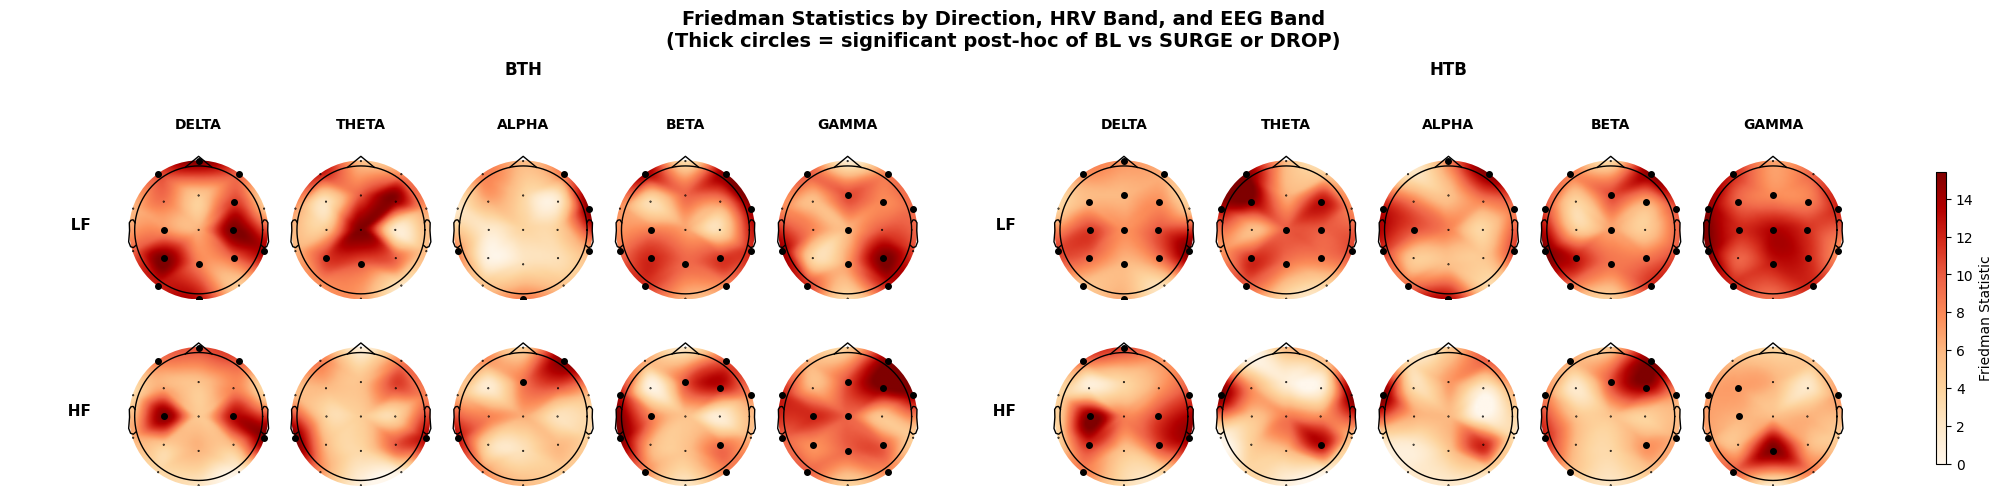

In [14]:
from mne.viz import plot_topomap

# Prepare data for topoplots
directions = friedman_df['direction'].unique()
eeg_bands = friedman_df['eeg_band'].unique()
hrv_bands = friedman_df['hrv_band'].unique()

# Group by direction, hrv_band, eeg_band and aggregate across channels
topo_data = []

for direction in directions:
    for hrv_band in hrv_bands:
        for eeg_band in eeg_bands:
            # Filter data for this combination
            subset = friedman_df[
                (friedman_df['direction'] == direction) &
                (friedman_df['hrv_band'] == hrv_band) &
                (friedman_df['eeg_band'] == eeg_band)
            ]
            
            # Get channel names and stats
            channels = subset['channel'].values
            stats = subset['friedman_stat'].values
            significant = subset['significant_posthoc'].values
            
            topo_data.append({
                'direction': direction,
                'hrv_band': hrv_band,
                'eeg_band': eeg_band,
                'channels': channels,
                'stats': stats,
                'significant': significant
            })

# Create figure with subplots
# 2 directions x 2 HRV bands x 5 EEG bands = 20 topoplots
n_directions = len(directions)
n_hrv_bands = len(hrv_bands)
n_eeg_bands = len(eeg_bands)

fig, axes = plt.subplots(n_hrv_bands, n_directions * n_eeg_bands, 
                         figsize=(20, 4.5), constrained_layout=True)

# Get channel positions from MNE info
info = channel_info
pos = mne.find_layout(info).pos

# Create channel name to position mapping
ch_names = info['ch_names']
ch_pos_dict = {ch: pos[i, :2] for i, ch in enumerate(ch_names)}

# Plot each topomap
for idx, data in enumerate(topo_data):
    direction = data['direction']
    hrv_band = data['hrv_band']
    eeg_band = data['eeg_band']
    
    # Determine subplot position
    dir_idx = list(directions).index(direction)
    hrv_idx = list(hrv_bands).index(hrv_band)
    eeg_idx = list(eeg_bands).index(eeg_band)

    row = hrv_idx
    col = dir_idx * n_eeg_bands + eeg_idx
    ax = axes[row, col]
    
    # Prepare data for topomap
    # Create array for all channels, fill with NaN for missing
    values = np.full(len(ch_names), np.nan)
    mask = np.zeros(len(ch_names), dtype=bool)
    
    for i, ch in enumerate(ch_names):
        if ch in data['channels']:
            ch_idx = np.where(data['channels'] == ch)[0][0]
            values[i] = data['stats'][ch_idx]
            mask[i] = data['significant'][ch_idx]
    
    # Plot topomap
    im, _ = plot_topomap(values, info, axes=ax, mask=mask, mask_params=dict(marker='o', markersize=4, markerfacecolor='black', markeredgecolor='black'), show=False, contours=0, cmap='OrRd')
    
    # Add title for first row
    if row == 0:
        ax.set_title(eeg_band.upper(), fontsize=10, fontweight='bold', pad=15)
    
    # Add direction label above first column of each direction
    if row == 0 and col % n_eeg_bands == n_eeg_bands // 2:
        ax.text(0.5, 1.5, direction.upper(), transform=ax.transAxes,
               fontsize=12, fontweight='bold', ha='center')
    
    # Add y-axis label for first column
    if col == 0 or col == n_eeg_bands:
        ylabel = "           " + hrv_band.upper()
        ax.text(-0.2, 0.5, ylabel, transform=ax.transAxes,
               fontsize=11, fontweight='bold', va='center', ha='right')

# Add main title
fig.suptitle('Friedman Statistics by Direction, HRV Band, and EEG Band\n(Thick circles = significant post-hoc of BL vs SURGE or DROP)', 
            fontsize=14, fontweight='bold', y=1.1)

# Add colorbar
cbar = fig.colorbar(im, ax=axes, location='right', shrink=0.8, aspect=30)
cbar.set_label('Friedman Statistic', fontsize=10)

plt.show()

Display distribution of event types across the different emotional arousal conditions.

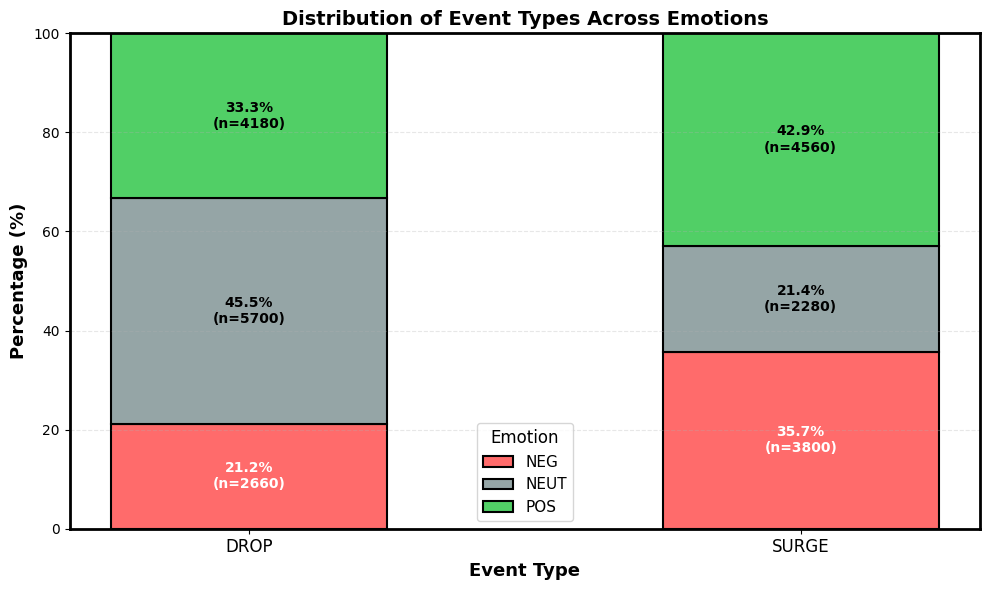

In [15]:
# Create contingency table
contingency = bhi_df.groupby(['event_type', 'emotion']).size().reset_index(name='count')
contingency_pivot = contingency.pivot(index='event_type', columns='emotion', values='count').fillna(0)

# Calculate percentages
percentages = contingency_pivot.div(contingency_pivot.sum(axis=1), axis=0) * 100

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for emotions
colors = {'NEG': '#ff6b6b', 'NEUT': '#95a5a6', 'POS': '#51cf66'}
emotions = ['NEG', 'NEUT', 'POS']

# Width of bars
bar_width = 0.5
x = np.arange(len(percentages.index))

# Create stacked bars
bottom = np.zeros(len(percentages.index))
for emotion in emotions:
    if emotion in percentages.columns:
        values = percentages[emotion].values
        counts = contingency_pivot[emotion].values
        bars = ax.bar(x, values, bar_width, bottom=bottom, 
                     label=emotion, color=colors[emotion], 
                     edgecolor='black', linewidth=1.5)
        
        # Add percentage and count labels on each segment
        for i, (bar, val, cnt) in enumerate(zip(bars, values, counts)):
            if val > 3:  # Only show label if segment is large enough
                ax.text(bar.get_x() + bar.get_width()/2, 
                       bottom[i] + val/2,
                       f'{val:.1f}%\n(n={int(cnt)})', 
                       ha='center', va='center', 
                       fontsize=10, fontweight='bold',
                       color='white' if emotion == 'NEG' else 'black')
        
        bottom += values

# Customize plot
ax.set_xlabel('Event Type', fontsize=13, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold')
ax.set_title('Distribution of Event Types Across Emotions', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(percentages.index, fontsize=12)
ax.set_ylim(0, 100)
ax.legend(title='Emotion', fontsize=11, title_fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add border
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

Calculate timeresolved Friedman statistics by taking medians of 5 second timesteps

In [16]:
# -------------------------------
# TIME-RESOLVED FRIEDMAN TEST WITH WILCOXON POST-HOC
# Split data into 5-second segments
# -------------------------------

# Create BHI epochs dataframe with padded data before and after events to reveal time dynamics
padded_bhi_df = create_bhi_dataframe(extreme_events, all_subjects, padding_seconds=10) # 10 seconds padding before and after => 30 seconds total

# Filter df to only include subjects with both SURGE and DROP events
padded_bhi_df = (
    padded_bhi_df
    .groupby("id")
    .filter(lambda g: {'SURGE', 'DROP'}.issubset(set(g["event_type"])))
)

# Collapse into a single SURGE and DROP per subject by taking element-wise median across events, resulting in one time series per subject per event type
collapsed_df = (
    padded_bhi_df
    .groupby(['id', 'direction', 'eeg_band', 'hrv_band', 'channel_label', 'event_type'])["data"]
    .apply(lambda x: np.median(np.vstack(x), axis=0))
    .unstack("event_type")              # X and Y become columns
    .rename(columns={"SURGE": "data_SURGE", "DROP": "data_DROP", "BL": "data_BL"})
    .reset_index()
)
collapsed_df.columns.name = None

collapsed_df


Processing i01...
Processing i02...
Processing i03...
Processing i04...
Processing i05...
Processing i06...
Processing i07...
Processing i08...
Processing i09...
Processing i10...
Processing i11...
Processing i12...
Processing i13...
Processing i14...
Processing i15...
Processing i19...
Processing i20...
Processing i21...
Processing i22...
Processing i23...
Processing i24...
Processing i25...
Processing i26...
Processing i27...


id direction eeg_band hrv_band channel_label  \
0     i04       BtH    alpha       hf            C3   
1     i04       BtH    alpha       hf            C4   
2     i04       BtH    alpha       hf            Cz   
3     i04       BtH    alpha       hf            F3   
4     i04       BtH    alpha       hf            F4   
...   ...       ...      ...      ...           ...   
5315  i27       HtB    theta       lf            P7   
5316  i27       HtB    theta       lf            P8   
5317  i27       HtB    theta       lf            Pz   
5318  i27       HtB    theta       lf            T7   
5319  i27       HtB    theta       lf            T8   

                                                data_BL  \
0     [2.998414746543416, 3.1578360616548213, 3.3744...   
1     [18.36223960287379, 18.895330617703447, 19.077...   
2     [11.632909510371766, 11.969456994507157, 12.34...   
3     [4.98519301569272, 5.204604912839821, 5.521560...   
4     [3.6788594820419536, 3.7650494863705766, 3.853...   
...                                                 ...   
5315  [2.95143947488841, 2.8712804779565464, 3.18154...   
5316  [3.46687965429465, 2.7214551404224276, 2.57380...   
5317  [1.2963803049054352, 1.0507216345208668, 0.919...   
5318  [3.045273955555641, 3.105160064607823, 3.20792...   
5319  [2.1624367200171752, 1.4519370072551534, 1.372...   

                                              data_DROP  \
0     [3.6863913023819683, 3.8905233990969763, 4.089...   
1     [1.7365598968222697, 1.7953336147984982, 1.831...   
2     [1.4903194716632677, 1.5091636441398462, 1.527...   
3     [1.3063667859793298, 1.3112921115373237, 1.310...   
4     [1.6964938433339332, 1.782327531762712, 1.7992...   
...                                                 ...   
5315  [0.23589484989601225, 0.26197161989846907, 0.2...   
5316  [0.08671302046402733, 0.09103782651139078, 0.0...   
5317  [0.26354996533611647, 0.28739619118841025, 0.2...   
5318  [0.299661779139592, 0.3054479514617637, 0.3025...   
5319  [0.0882630359172241, 0.09449030767047031, 0.10...   

                                             data_SURGE  
0     [1.4910866746047324, 1.445673251908803, 1.3887...  
1     [0.6679914016444722, 0.6497758855872063, 0.705...  
2     [0.6405614118306842, 0.6183204590684925, 0.631...  
3     [0.9195547856338053, 0.8593580527343435, 0.859...  
4     [0.7196715446934412, 0.7233103849431062, 0.751...  
...                                                 ...  
5315  [0.11988714828751489, 0.12150044869009786, 0.1...  
5316  [0.014136122557061745, 0.012824815587317075, 0...  
5317  [0.06379314865737083, 0.044136698057826364, 0....  
5318  [0.08693739109062061, 0.07792300499305076, 0.0...  
5319  [0.04748658206283902, 0.04674931533306779, 0.0...  

[5320 rows x 8 columns]

In [17]:
# Determine the maximum epoch length to define time segments
max_epoch_length = max([len(epoch_data) for epoch_data in collapsed_df['data_SURGE']])
sampling_rate = 2  # BHI sampling rate (2 Hz)
segment_duration = 5  # seconds
segment_samples = segment_duration * sampling_rate  # 10 samples per segment

# Calculate number of segments
n_segments = int(np.ceil(max_epoch_length / segment_samples))

print(f"Max epoch length: {max_epoch_length} samples")
print(f"Number of 5-second segments: {n_segments}")


Max epoch length: 60 samples
Number of 5-second segments: 6


In [18]:

# Store results for each time segment
time_resolved_results = []

for seg_idx in range(n_segments):
    print(f"\nProcessing segment {seg_idx + 1}/{n_segments} ({seg_idx*5}-{(seg_idx+1)*5}s)...")
    
    segment_start = seg_idx * segment_samples
    segment_end = (seg_idx + 1) * segment_samples
    
    friedman_results = []
    
    for direction in collapsed_df['direction'].unique():
        for eeg_band in collapsed_df['eeg_band'].unique():
            for hrv_band in collapsed_df['hrv_band'].unique():
                for channel in collapsed_df['channel_label'].unique():

                    # Select data for this combination
                    sub_df = collapsed_df[
                        (collapsed_df.direction == direction) &
                        (collapsed_df.eeg_band == eeg_band) &
                        (collapsed_df.hrv_band == hrv_band) &
                        (collapsed_df.channel_label == channel)
                    ].copy()

                    def get_segment_median(x):
                        if len(x) > segment_start:
                            return np.median(x[segment_start:segment_end])
                        else:
                            return np.nan

                    # median BHI per subject for each event type in this segment
                    bl = sub_df['data_BL'].apply(get_segment_median)
                    surge = sub_df['data_SURGE'].apply(get_segment_median)
                    drop = sub_df['data_DROP'].apply(get_segment_median)

                    # Friedman test across 3 conditions (BL, SURGE, DROP)
                    try:
                        friedman_stat, friedman_p = friedmanchisquare(bl, surge, drop)
                    except:
                        print(f"  ✗ Segment {seg_idx}, {direction}, {eeg_band}, {hrv_band}, {channel}: Friedman test failed")
                        continue

                    # Post-hoc pairwise Wilcoxon tests (if Friedman is significant)
                    posthoc_results = {}
                    if friedman_p < 0.05:
                        # BL vs SURGE
                        try:
                            w_stat_bl_surge, p_bl_surge = wilcoxon(bl, surge)
                            posthoc_results['BL_vs_SURGE'] = {'stat': w_stat_bl_surge, 'p': p_bl_surge}
                        except:
                            p_bl_surge = 1.0
                            posthoc_results['BL_vs_SURGE'] = {'stat': np.nan, 'p': p_bl_surge}

                        # BL vs DROP
                        try:
                            w_stat_bl_drop, p_bl_drop = wilcoxon(bl, drop)
                            posthoc_results['BL_vs_DROP'] = {'stat': w_stat_bl_drop, 'p': p_bl_drop}
                        except:
                            p_bl_drop = 1.0
                            posthoc_results['BL_vs_DROP'] = {'stat': np.nan, 'p': p_bl_drop}

                        # SURGE vs DROP
                        try:
                            w_stat_surge_drop, p_surge_drop = wilcoxon(surge, drop)
                            posthoc_results['SURGE_vs_DROP'] = {'stat': w_stat_surge_drop, 'p': p_surge_drop}
                        except:
                            p_surge_drop = 1.0
                            posthoc_results['SURGE_vs_DROP'] = {'stat': np.nan, 'p': p_surge_drop}

                        # Apply Bonferroni correction for 3 comparisons
                        pvals = [p_bl_surge, p_bl_drop, p_surge_drop]
                        rejected, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')

                        posthoc_results['BL_vs_SURGE']['p_corrected'] = pvals_corrected[0]
                        posthoc_results['BL_vs_SURGE']['significant'] = rejected[0]

                        posthoc_results['BL_vs_DROP']['p_corrected'] = pvals_corrected[1]
                        posthoc_results['BL_vs_DROP']['significant'] = rejected[1]

                        posthoc_results['SURGE_vs_DROP']['p_corrected'] = pvals_corrected[2]
                        posthoc_results['SURGE_vs_DROP']['significant'] = rejected[2]

                    friedman_results.append({
                        'segment': seg_idx,
                        'time_start': seg_idx * segment_duration,
                        'time_end': (seg_idx + 1) * segment_duration,
                        'direction': direction,
                        'eeg_band': eeg_band,
                        'hrv_band': hrv_band,
                        'channel': channel,
                        'n_subjects': len(common_ids),
                        'friedman_stat': friedman_stat,
                        'friedman_p': friedman_p,
                        'significant': friedman_p < 0.05,
                        'posthoc': posthoc_results if friedman_p < 0.05 else None,
                        'significant_posthoc': (posthoc_results['BL_vs_SURGE']['significant'] or 
                                               posthoc_results['BL_vs_DROP']['significant']) if friedman_p < 0.05 else False,
                    })
    
    time_resolved_results.extend(friedman_results)

# Convert to DataFrame
time_resolved_friedman_df = pd.DataFrame(time_resolved_results)


Processing segment 1/6 (0-5s)...

Processing segment 2/6 (5-10s)...

Processing segment 3/6 (10-15s)...

Processing segment 4/6 (15-20s)...

Processing segment 5/6 (20-25s)...

Processing segment 6/6 (25-30s)...


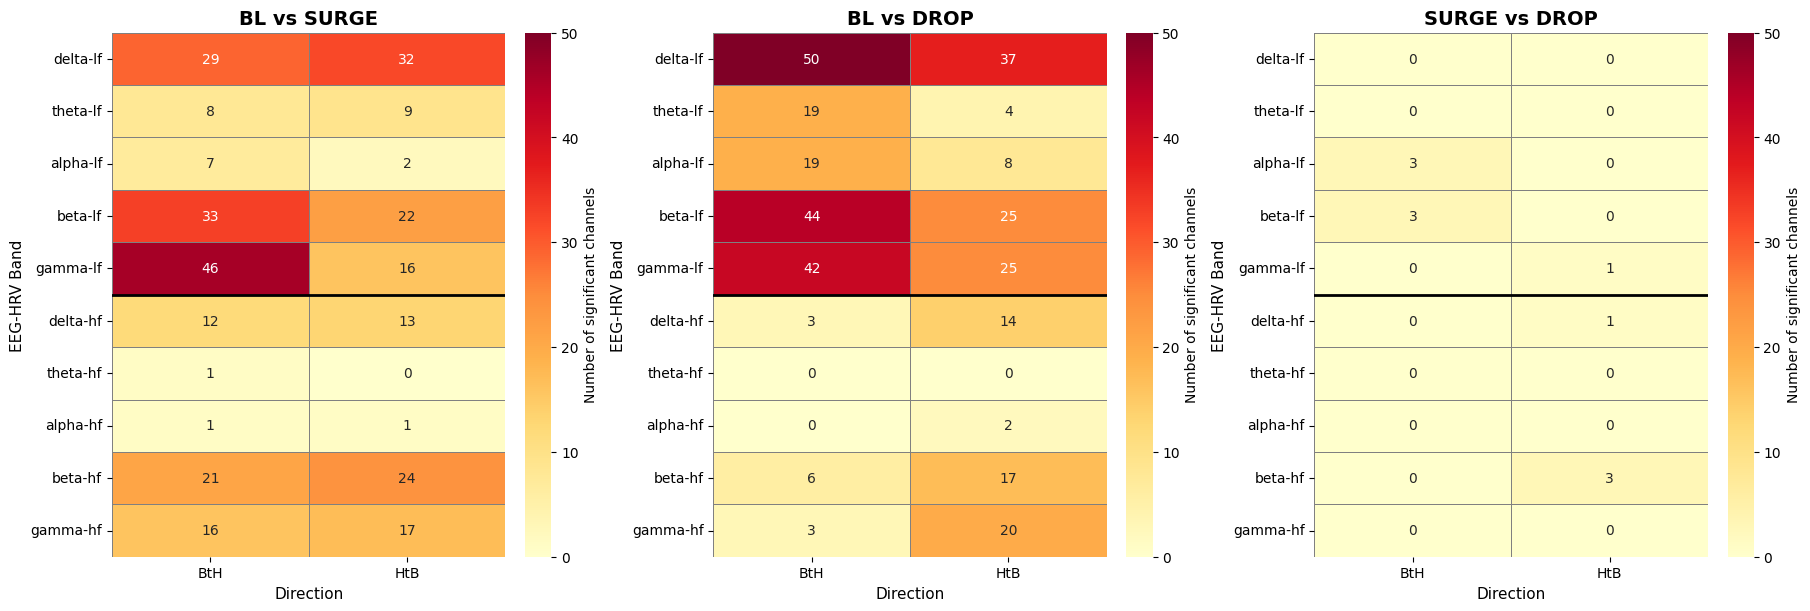

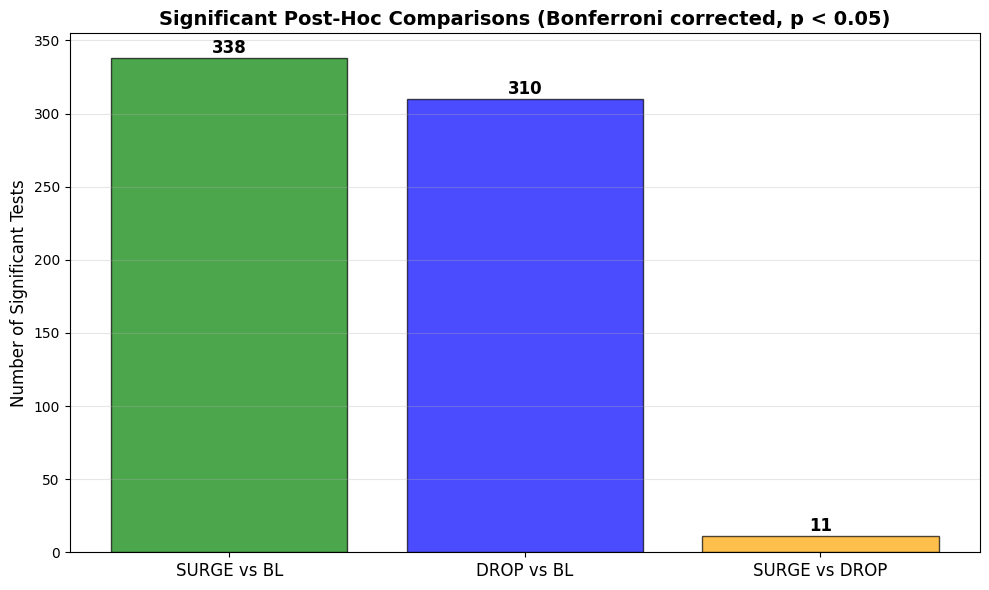

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract post-hoc comparison results for visualization
posthoc_viz_data = []
for _, row in time_resolved_friedman_df.iterrows():
    if row["posthoc"] is not None:
        for comparison, results in row["posthoc"].items():
            posthoc_viz_data.append(
                {
                    "direction": row["direction"],
                    "eeg_band": row["eeg_band"],
                    "hrv_band": row["hrv_band"],
                    "channel": row["channel"],
                    "comparison": comparison,
                    "significant": results["significant"],
                    "p_corrected": results["p_corrected"],
                }
            )

posthoc_df = pd.DataFrame(posthoc_viz_data)

comparisons = ["BL_vs_SURGE", "BL_vs_DROP", "SURGE_vs_DROP"]
titles = ["BL vs SURGE", "BL vs DROP", "SURGE vs DROP"]

# Fixed ordering for axes/index
eeg_bands = ["delta", "theta", "alpha", "beta", "gamma"]
hrv_bands = ["lf", "hf"]
all_band_combos = [f"{eeg}-lf" for eeg in eeg_bands] + [f"{eeg}-hf" for eeg in eeg_bands]

all_directions = collapsed_df["direction"].unique()

# --- build all heatmaps first (so we can share the same color scale) ---
heatmaps = {}
for comp in comparisons:
    comp_data = posthoc_df[posthoc_df["comparison"] == comp]

    pivot_data = (
        comp_data[comp_data["significant"]]
        .groupby(["direction", "eeg_band", "hrv_band"])
        .size()
        .reset_index(name="count")
    )
    pivot_data["band_combo"] = pivot_data["eeg_band"] + "-" + pivot_data["hrv_band"]

    hm = pivot_data.pivot_table(
        index="band_combo",
        columns="direction",
        values="count",
        fill_value=0,
    )

    hm = hm.reindex(index=all_band_combos, columns=all_directions, fill_value=0)
    heatmaps[comp] = hm

# Shared color scale across comparisons
vmin = 0
vmax = int(max(hm.to_numpy().max() for hm in heatmaps.values())) if heatmaps else 0
if vmax == 0:
    vmax = 1  # avoid all-white heatmaps when everything is zero

# --- plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for ax, comp, title in zip(axes, comparisons, titles):
    sns.heatmap(
        heatmaps[comp],
        annot=True,
        fmt="g",
        cmap="YlOrRd",
        vmin=vmin,
        vmax=vmax,  # <- normalized across panels
        cbar_kws={"label": "Number of significant channels"},
        ax=ax,
        linewidths=0.5,
        linecolor="gray",
    )
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Direction", fontsize=11)
    ax.set_ylabel("EEG-HRV Band", fontsize=11)
    ax.axhline(y=len(eeg_bands), color="black", linewidth=2)  # LF/HF separator

plt.show()

# 3. Bar plot: Total significant channels per comparison across all conditions
fig, ax = plt.subplots(figsize=(10, 6))

comparison_summary = posthoc_df.groupby(['comparison', 'significant']).size().unstack(fill_value=0)

if True in comparison_summary.columns:
    sig_counts = comparison_summary[True]
    
    colors = ['green', 'blue', 'orange']
    bars = ax.bar(range(len(sig_counts)), sig_counts.values, color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sig_counts.values)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
               f'{int(val)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_xticks(range(len(sig_counts)))
    ax.set_xticklabels(['SURGE vs BL', 'DROP vs BL', 'SURGE vs DROP'], fontsize=12)
    ax.set_ylabel('Number of Significant Tests', fontsize=12)
    ax.set_title('Significant Post-Hoc Comparisons (Bonferroni corrected, p < 0.05)', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No significant comparisons found")

Visualize topomaps of time-resolved Friedman statistics with significant post-hoc results.

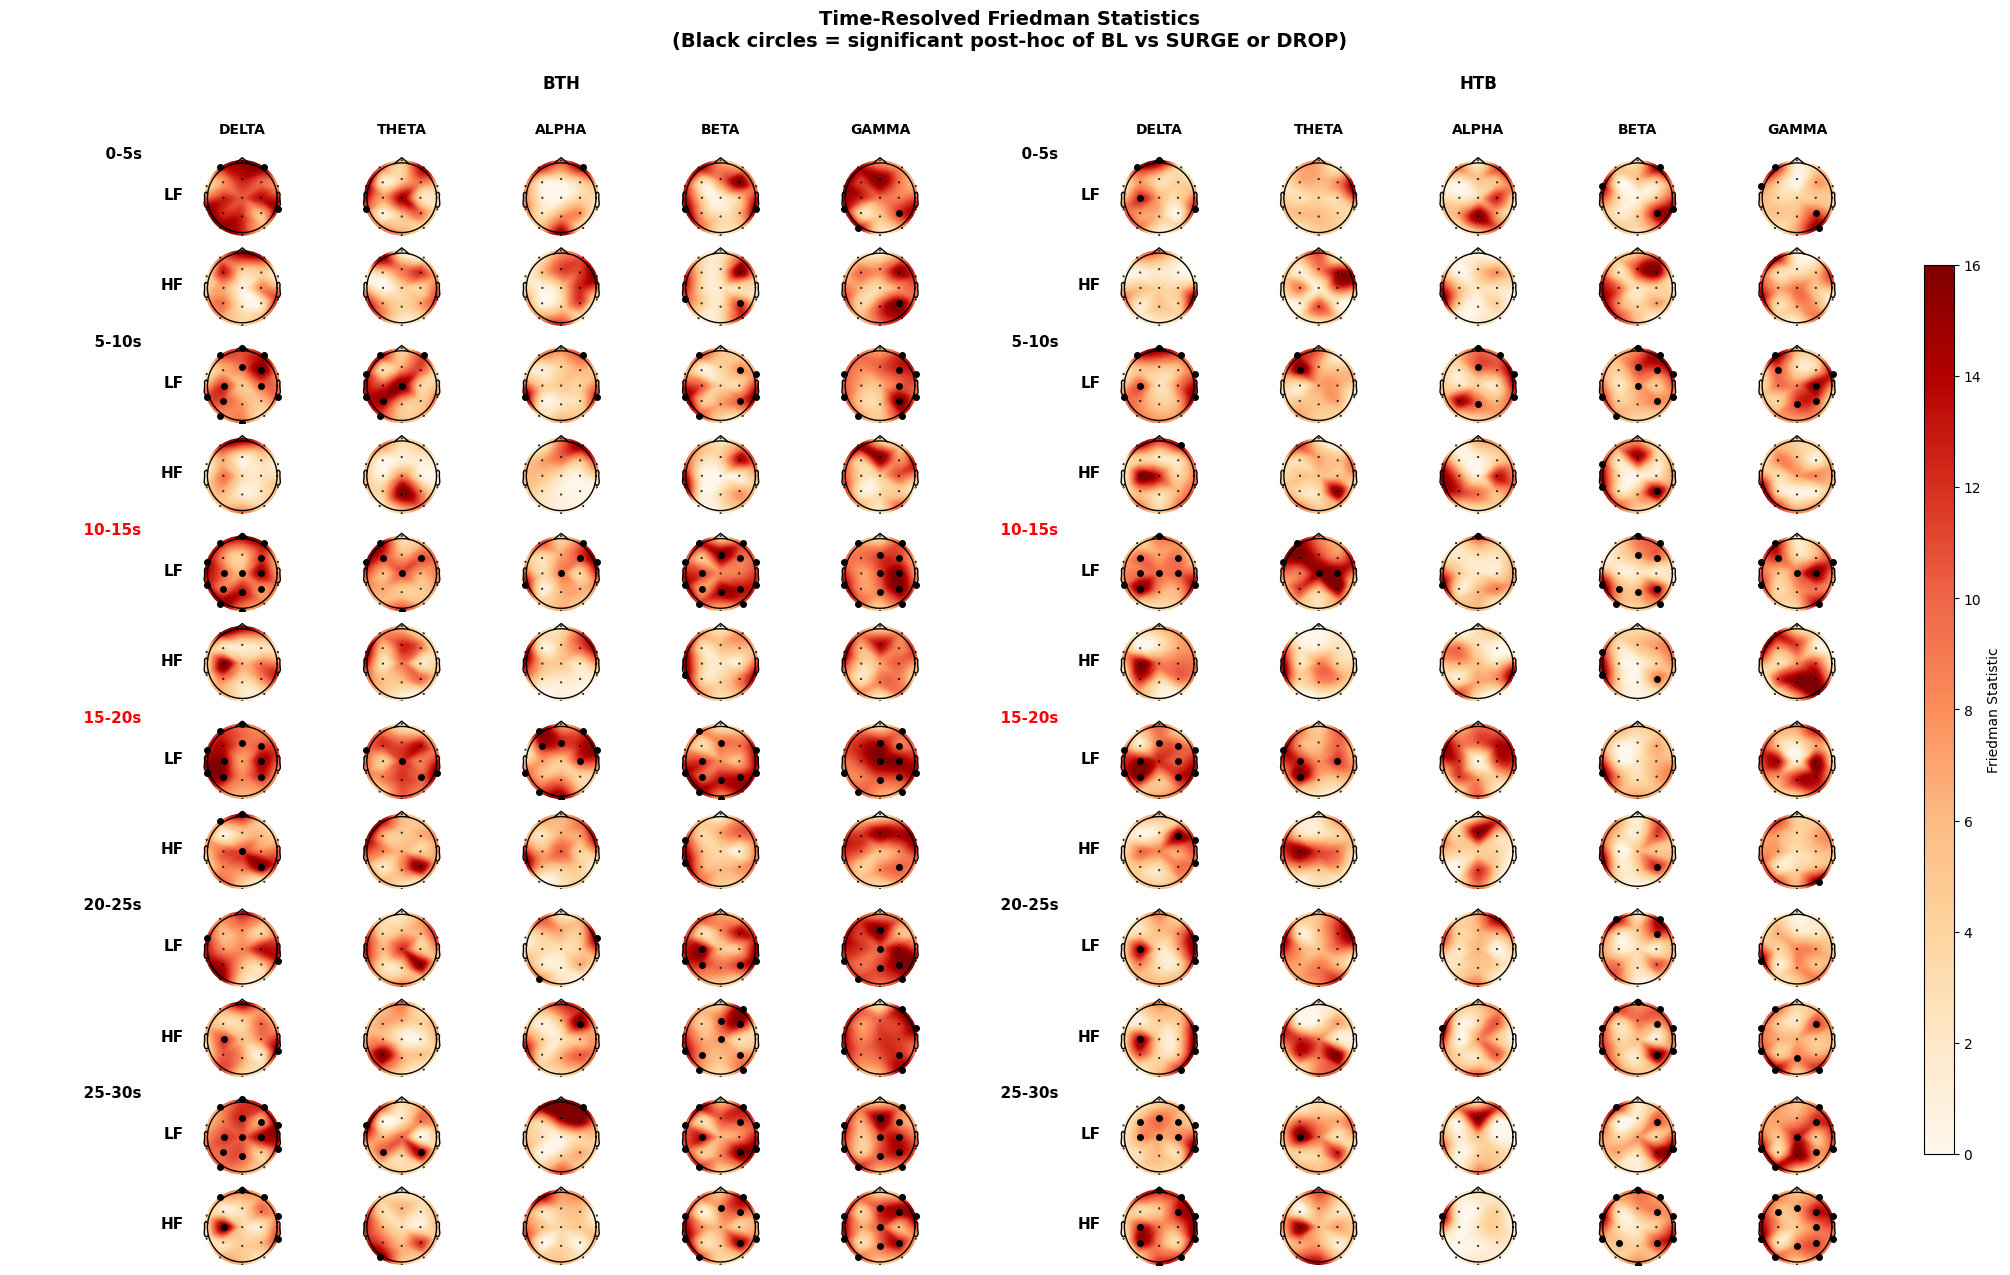

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne.viz import plot_topomap

# Prepare data for time-resolved topoplots - ONLY LF BAND
segments = sorted(time_resolved_friedman_df['segment'].unique())
directions = time_resolved_friedman_df['direction'].unique()

eeg_bands = time_resolved_friedman_df['eeg_band'].unique()
hrv_bands = time_resolved_friedman_df['hrv_band'].unique()
# Sort EEG bands and HRV bands in desired order
eeg_band_order = ['delta', 'theta', 'alpha', 'beta', 'gamma']
hrv_band_order = ['lf', 'hf']
# Filter and sort to only include existing bands in the specified order
eeg_bands = [band for band in eeg_band_order if band in eeg_bands]
hrv_bands = [band for band in hrv_band_order if band in hrv_bands]

# Get channel info
info = channel_info
ch_names = info['ch_names']

# Group data by time segment, direction, eeg_band (LF only)
topo_data = []

for segment in segments:
    for direction in directions:
        for hrv_band in hrv_bands:
            for eeg_band in eeg_bands:
                # Filter data for this combination - LF ONLY
                subset = time_resolved_friedman_df[
                    (time_resolved_friedman_df['segment'] == segment) &
                    (time_resolved_friedman_df['direction'] == direction) &
                    (time_resolved_friedman_df['hrv_band'] == hrv_band) &
                    (time_resolved_friedman_df['eeg_band'] == eeg_band)
                ]
                
                if len(subset) == 0:
                    continue
                
                # Get channel names and stats
                channels = subset['channel'].values
                stats = subset['friedman_stat'].values
                significant = subset['significant_posthoc'].values
                
                topo_data.append({
                    'segment': segment,
                    'time_start': segment * 5,
                    'time_end': (segment + 1) * 5,
                    'direction': direction,
                    'hrv_band': hrv_band,
                    'eeg_band': eeg_band,
                    'channels': channels,
                    'stats': stats,
                    'significant': significant
                })

# Create figure with subplots
# Rows = time segments, Columns = 2 directions x 5 eeg_bands = 10
n_segments = len(segments)
n_directions = len(directions)
n_eeg_bands = len(eeg_bands)
n_hrv_bands = len(hrv_bands)

fig, axes = plt.subplots(n_segments * n_hrv_bands, n_directions * n_eeg_bands, 
                         figsize=(20, n_segments * 2), constrained_layout=True)

# Ensure axes is 2D
if n_segments == 1:
    axes = axes.reshape(1, -1)

# Plot each topomap
for idx, data in enumerate(topo_data):
    segment = data['segment']
    direction = data['direction']
    eeg_band = data['eeg_band']
    hrv_band = data['hrv_band']
    
    # Determine subplot position
    seg_idx = list(segments).index(segment)
    dir_idx = list(directions).index(direction)
    eeg_idx = list(eeg_bands).index(eeg_band)
    hrv_idx = list(hrv_bands).index(hrv_band)
    
    row = seg_idx * n_hrv_bands + hrv_idx
    col = dir_idx * n_eeg_bands + eeg_idx
    ax = axes[row, col]
    
    # Prepare data for topomap
    values = np.full(len(ch_names), np.nan)
    mask = np.zeros(len(ch_names), dtype=bool)
    
    for i, ch in enumerate(ch_names):
        if ch in data['channels']:
            ch_idx = np.where(data['channels'] == ch)[0][0]
            values[i] = data['stats'][ch_idx]
            mask[i] = data['significant'][ch_idx]
    
    # Plot topomap
    im, _ = plot_topomap(values, info, axes=ax, mask=mask, 
                        mask_params=dict(marker='o', markersize=4, 
                                       markerfacecolor='black', 
                                       markeredgecolor='black'), 
                        show=False, contours=0, cmap='OrRd')
    
    # Add EEG band title for first row
    if row == 0:
        ax.set_title(eeg_band.upper(), fontsize=10, fontweight='bold', pad=15)
    
    # Add direction label above center of each direction section
    if row == 0 and col % n_eeg_bands == n_eeg_bands // 2:
        ax.text(0.5, 1.8, direction.upper(), transform=ax.transAxes,
               fontsize=12, fontweight='bold', ha='center')
    
    # Add time and HRV band labels on the left
    if col == 0 or col == n_eeg_bands:
        # Show time for first HRV band (LF) of each segment
        if hrv_idx == 0:
            time_label = "              " + f'{data["time_start"]}-{data["time_end"]}s'
            ax.text(-0.7, 1.0, time_label, transform=ax.transAxes,
                   fontsize=11, fontweight='bold', va='center', ha='right', color='red' if data["time_start"] == 10 or data["time_end"] == 20 else 'black')
        
        # Show HRV band label
        ylabel = hrv_band.upper()
        ax.text(-0.2, 0.5, ylabel, transform=ax.transAxes,
               fontsize=11, fontweight='bold', va='center', ha='right')

# Add main title
fig.suptitle('Time-Resolved Friedman Statistics\n(Black circles = significant post-hoc of BL vs SURGE or DROP)', 
            fontsize=14, fontweight='bold', y=1.05)

# Add colorbar
cbar = fig.colorbar(im, ax=axes, location='right', shrink=0.8, aspect=30)
cbar.set_label('Friedman Statistic', fontsize=10)

plt.show()

Repeat time resolved Friedman analysis using local baselines (first 5 seconds of each event) instead of global subject rest baselines.

In [21]:

# Store results for each time segment
local_bl_time_resolved_results = []

for seg_idx in range(n_segments):
    print(f"\nProcessing segment {seg_idx + 1}/{n_segments} ({seg_idx*5}-{(seg_idx+1)*5}s)...")
    
    segment_start = seg_idx * segment_samples
    segment_end = (seg_idx + 1) * segment_samples
    
    friedman_results = []
    
    for direction in collapsed_df['direction'].unique():
        for eeg_band in collapsed_df['eeg_band'].unique():
            for hrv_band in collapsed_df['hrv_band'].unique():
                for channel in collapsed_df['channel_label'].unique():

                    # Select data for this combination
                    sub_df = collapsed_df[
                        (collapsed_df.direction == direction) &
                        (collapsed_df.eeg_band == eeg_band) &
                        (collapsed_df.hrv_band == hrv_band) &
                        (collapsed_df.channel_label == channel)
                    ].copy()

                    def get_segment_median(x):
                        if len(x) > segment_start:
                            return np.median(x[segment_start:segment_end])
                        else:
                            return np.nan
                        
                    def get_local_bl_median(surge_data, drop_data):
                        avg = (surge_data + drop_data) / 2
                        return np.median(avg[0:segment_samples])  # Local BL is first segment

                    # median BHI per subject for each event type in this segment
                    surge = sub_df['data_SURGE'].apply(get_segment_median)
                    drop = sub_df['data_DROP'].apply(get_segment_median)
                    bl = sub_df.apply(lambda row: get_local_bl_median(row['data_SURGE'], row['data_DROP']), axis=1)

                    # Friedman test across 3 conditions (BL, SURGE, DROP)
                    try:
                        friedman_stat, friedman_p = friedmanchisquare(bl, surge, drop)
                    except:
                        print(f"  ✗ Segment {seg_idx}, {direction}, {eeg_band}, {hrv_band}, {channel}: Friedman test failed")
                        continue

                    # Post-hoc pairwise Wilcoxon tests (if Friedman is significant)
                    posthoc_results = {}
                    if friedman_p < 0.05:
                        # BL vs SURGE
                        try:
                            w_stat_bl_surge, p_bl_surge = wilcoxon(bl, surge)
                            posthoc_results['BL_vs_SURGE'] = {'stat': w_stat_bl_surge, 'p': p_bl_surge}
                        except:
                            p_bl_surge = 1.0
                            posthoc_results['BL_vs_SURGE'] = {'stat': np.nan, 'p': p_bl_surge}

                        # BL vs DROP
                        try:
                            w_stat_bl_drop, p_bl_drop = wilcoxon(bl, drop)
                            posthoc_results['BL_vs_DROP'] = {'stat': w_stat_bl_drop, 'p': p_bl_drop}
                        except:
                            p_bl_drop = 1.0
                            posthoc_results['BL_vs_DROP'] = {'stat': np.nan, 'p': p_bl_drop}

                        # SURGE vs DROP
                        try:
                            w_stat_surge_drop, p_surge_drop = wilcoxon(surge, drop)
                            posthoc_results['SURGE_vs_DROP'] = {'stat': w_stat_surge_drop, 'p': p_surge_drop}
                        except:
                            p_surge_drop = 1.0
                            posthoc_results['SURGE_vs_DROP'] = {'stat': np.nan, 'p': p_surge_drop}

                        # Apply Bonferroni correction for 3 comparisons
                        pvals = [p_bl_surge, p_bl_drop, p_surge_drop]
                        rejected, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')

                        posthoc_results['BL_vs_SURGE']['p_corrected'] = pvals_corrected[0]
                        posthoc_results['BL_vs_SURGE']['significant'] = rejected[0]

                        posthoc_results['BL_vs_DROP']['p_corrected'] = pvals_corrected[1]
                        posthoc_results['BL_vs_DROP']['significant'] = rejected[1]

                        posthoc_results['SURGE_vs_DROP']['p_corrected'] = pvals_corrected[2]
                        posthoc_results['SURGE_vs_DROP']['significant'] = rejected[2]

                    friedman_results.append({
                        'segment': seg_idx,
                        'time_start': seg_idx * segment_duration,
                        'time_end': (seg_idx + 1) * segment_duration,
                        'direction': direction,
                        'eeg_band': eeg_band,
                        'hrv_band': hrv_band,
                        'channel': channel,
                        'n_subjects': len(common_ids),
                        'friedman_stat': friedman_stat,
                        'friedman_p': friedman_p,
                        'significant': friedman_p < 0.05,
                        'posthoc': posthoc_results if friedman_p < 0.05 else None,
                        'significant_posthoc': {
                            'BL_vs_SURGE': posthoc_results['BL_vs_SURGE']['significant'] if friedman_p < 0.05 else False,
                            'BL_vs_DROP': posthoc_results['BL_vs_DROP']['significant'] if friedman_p < 0.05 else False,
                            'SURGE_vs_DROP': posthoc_results['SURGE_vs_DROP']['significant'] if friedman_p < 0.05 else False,
                        }
                    })
    
    local_bl_time_resolved_results.extend(friedman_results)

# Convert to DataFrame
local_bl_time_resolved_friedman_df = pd.DataFrame(local_bl_time_resolved_results)


Processing segment 1/6 (0-5s)...

Processing segment 2/6 (5-10s)...

Processing segment 3/6 (10-15s)...

Processing segment 4/6 (15-20s)...

Processing segment 5/6 (20-25s)...

Processing segment 6/6 (25-30s)...


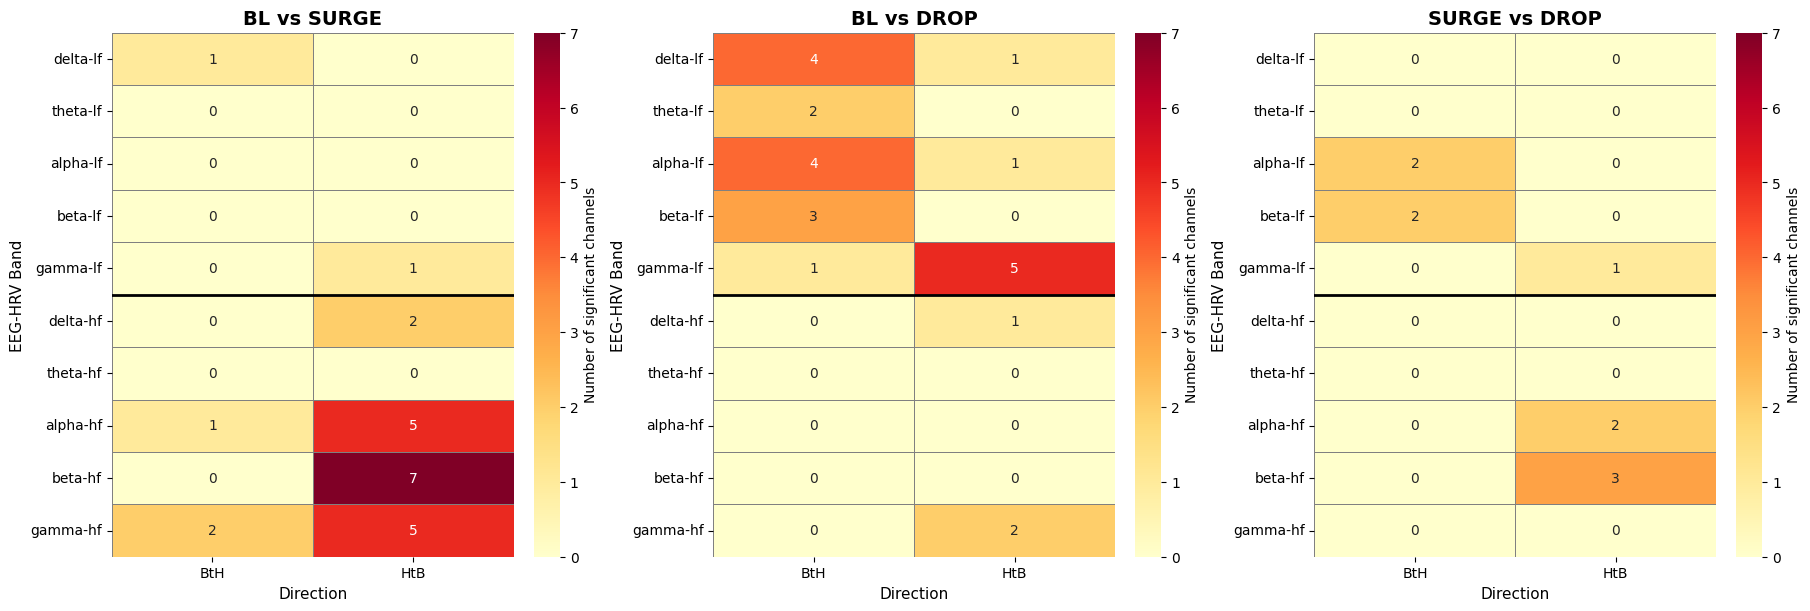

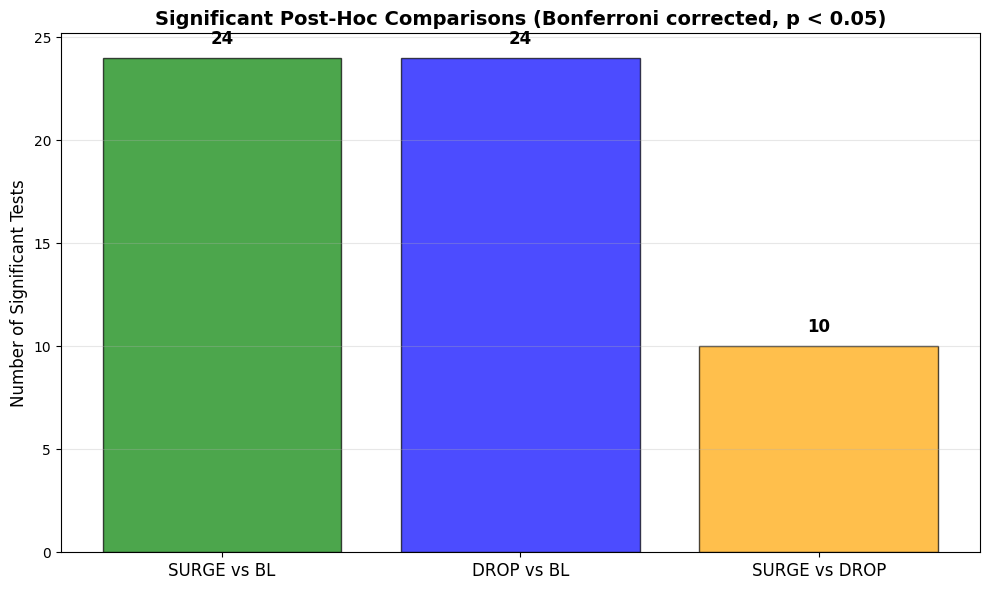

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract post-hoc comparison results for visualization
posthoc_viz_data = []
for _, row in local_bl_time_resolved_friedman_df.iterrows():
    if row["posthoc"] is not None:
        for comparison, results in row["posthoc"].items():
            posthoc_viz_data.append(
                {
                    "direction": row["direction"],
                    "eeg_band": row["eeg_band"],
                    "hrv_band": row["hrv_band"],
                    "channel": row["channel"],
                    "comparison": comparison,
                    "significant": results["significant"],
                    "p_corrected": results["p_corrected"],
                }
            )

posthoc_df = pd.DataFrame(posthoc_viz_data)

comparisons = ["BL_vs_SURGE", "BL_vs_DROP", "SURGE_vs_DROP"]
titles = ["BL vs SURGE", "BL vs DROP", "SURGE vs DROP"]

# Fixed ordering for axes/index
eeg_bands = ["delta", "theta", "alpha", "beta", "gamma"]
hrv_bands = ["lf", "hf"]
all_band_combos = [f"{eeg}-lf" for eeg in eeg_bands] + [f"{eeg}-hf" for eeg in eeg_bands]

all_directions = collapsed_df["direction"].unique()

# --- build all heatmaps first (so we can share the same color scale) ---
heatmaps = {}
for comp in comparisons:
    comp_data = posthoc_df[posthoc_df["comparison"] == comp]

    pivot_data = (
        comp_data[comp_data["significant"]]
        .groupby(["direction", "eeg_band", "hrv_band"])
        .size()
        .reset_index(name="count")
    )
    pivot_data["band_combo"] = pivot_data["eeg_band"] + "-" + pivot_data["hrv_band"]

    hm = pivot_data.pivot_table(
        index="band_combo",
        columns="direction",
        values="count",
        fill_value=0,
    )

    hm = hm.reindex(index=all_band_combos, columns=all_directions, fill_value=0)
    heatmaps[comp] = hm

# Shared color scale across comparisons
vmin = 0
vmax = int(max(hm.to_numpy().max() for hm in heatmaps.values())) if heatmaps else 0
if vmax == 0:
    vmax = 1  # avoid all-white heatmaps when everything is zero

# --- plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for ax, comp, title in zip(axes, comparisons, titles):
    sns.heatmap(
        heatmaps[comp],
        annot=True,
        fmt="g",
        cmap="YlOrRd",
        vmin=vmin,
        vmax=vmax,  # <- normalized across panels
        cbar_kws={"label": "Number of significant channels"},
        ax=ax,
        linewidths=0.5,
        linecolor="gray",
    )
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Direction", fontsize=11)
    ax.set_ylabel("EEG-HRV Band", fontsize=11)
    ax.axhline(y=len(eeg_bands), color="black", linewidth=2)  # LF/HF separator

plt.show()

# 3. Bar plot: Total significant channels per comparison across all conditions
fig, ax = plt.subplots(figsize=(10, 6))

comparison_summary = posthoc_df.groupby(['comparison', 'significant']).size().unstack(fill_value=0)

if True in comparison_summary.columns:
    sig_counts = comparison_summary[True]
    
    colors = ['green', 'blue', 'orange']
    bars = ax.bar(range(len(sig_counts)), sig_counts.values, color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sig_counts.values)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
               f'{int(val)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_xticks(range(len(sig_counts)))
    ax.set_xticklabels(['SURGE vs BL', 'DROP vs BL', 'SURGE vs DROP'], fontsize=12)
    ax.set_ylabel('Number of Significant Tests', fontsize=12)
    ax.set_title('Significant Post-Hoc Comparisons (Bonferroni corrected, p < 0.05)', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No significant comparisons found")

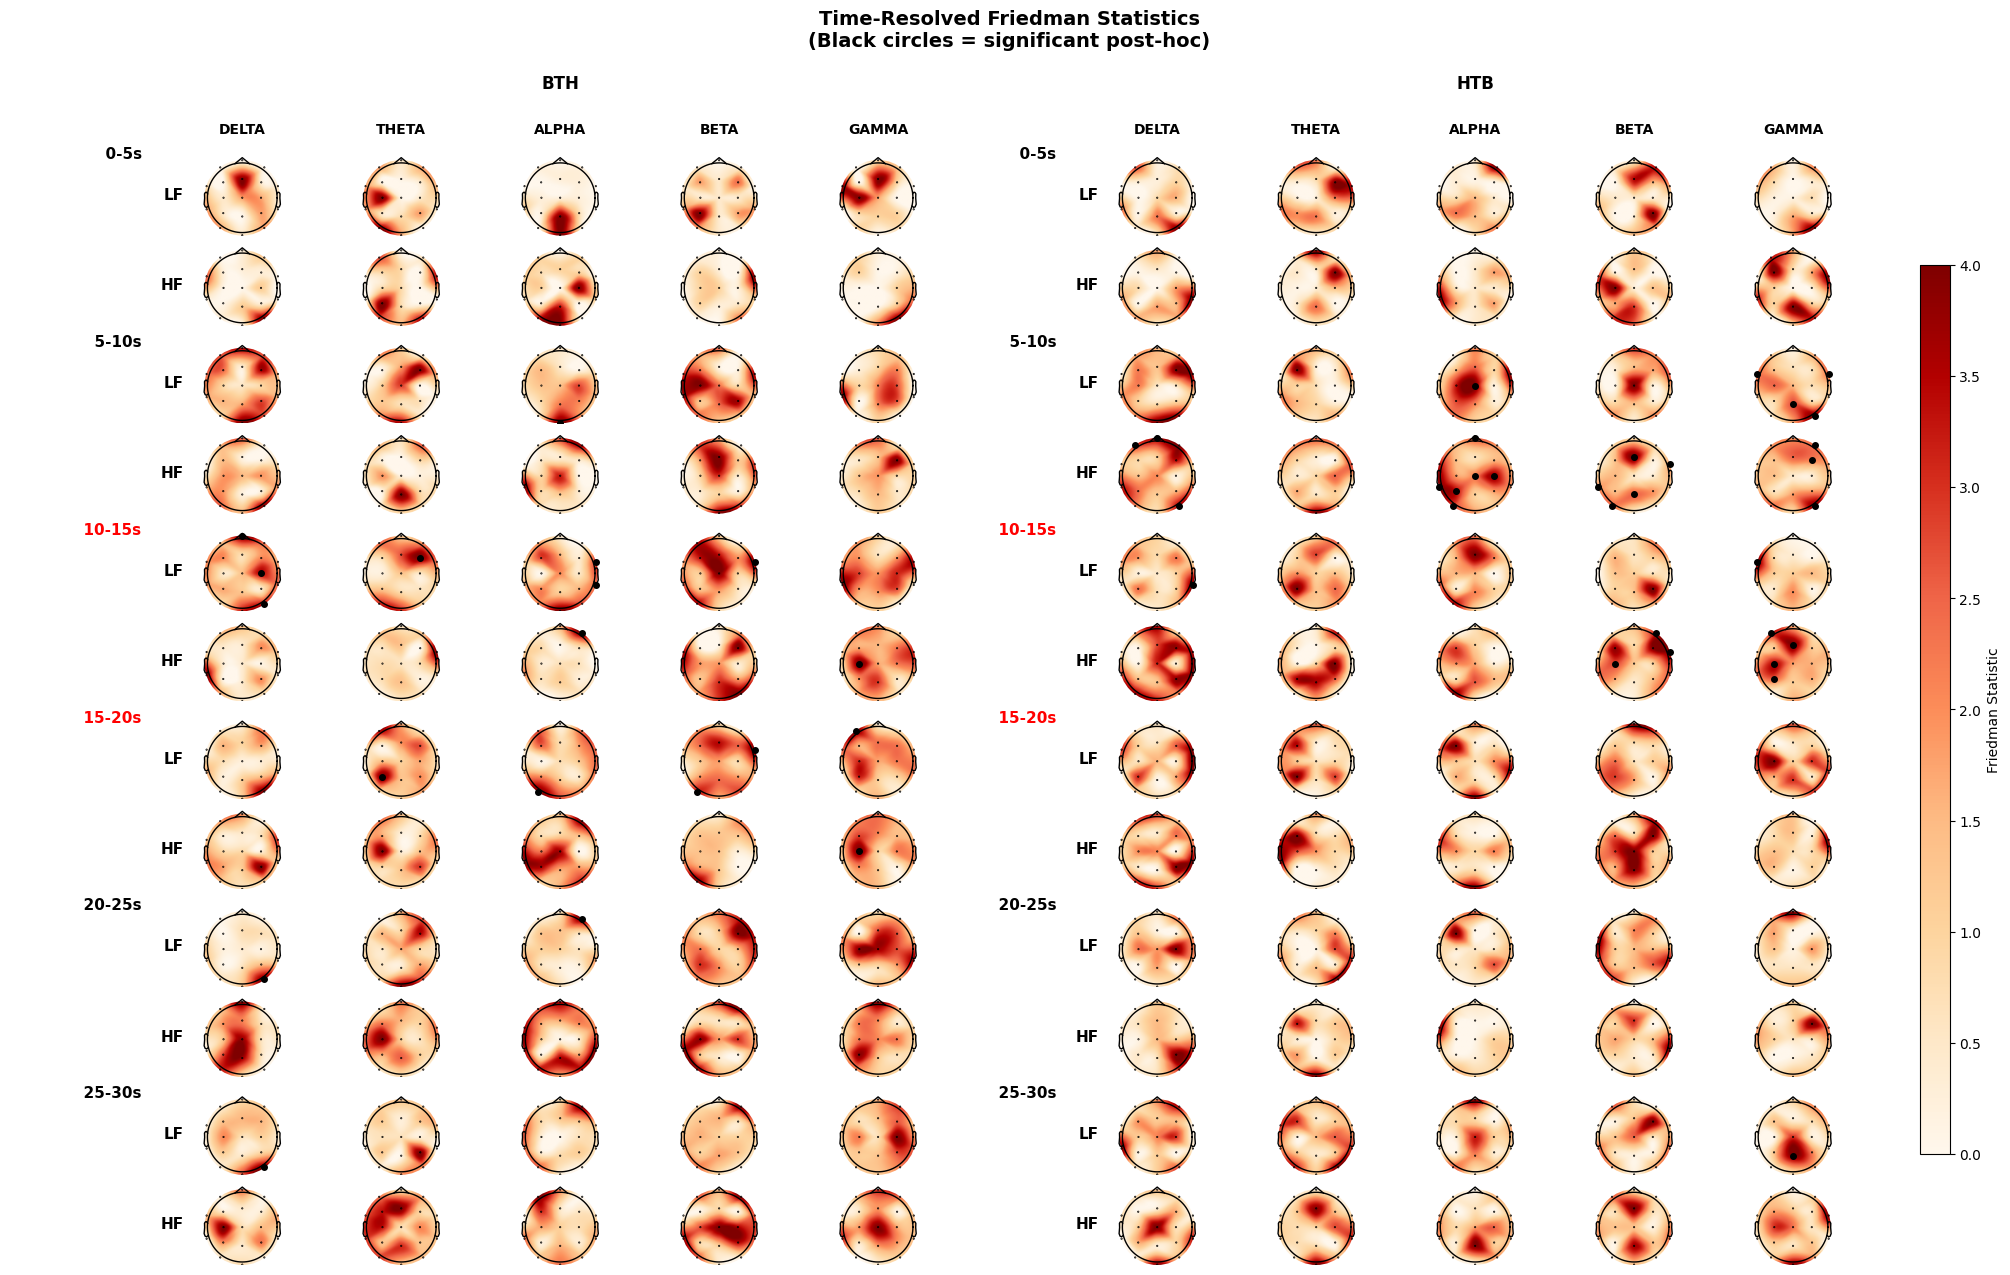

In [30]:
# Prepare data for time-resolved topoplots - ONLY LF BAND
segments = sorted(local_bl_time_resolved_friedman_df['segment'].unique())
directions = local_bl_time_resolved_friedman_df['direction'].unique()

eeg_bands = local_bl_time_resolved_friedman_df['eeg_band'].unique()
hrv_bands = local_bl_time_resolved_friedman_df['hrv_band'].unique()
# Sort EEG bands and HRV bands in desired order
eeg_band_order = ['delta', 'theta', 'alpha', 'beta', 'gamma']
hrv_band_order = ['lf', 'hf']
# Filter and sort to only include existing bands in the specified order
eeg_bands = [band for band in eeg_band_order if band in eeg_bands]
hrv_bands = [band for band in hrv_band_order if band in hrv_bands]

# Get channel info
info = channel_info
ch_names = info['ch_names']

# Group data by time segment, direction, eeg_band (LF only)
topo_data = []

for segment in segments:
    for direction in directions:
        for hrv_band in hrv_bands:
            for eeg_band in eeg_bands:
                # Filter data for this combination - LF ONLY
                subset = local_bl_time_resolved_friedman_df[
                    (local_bl_time_resolved_friedman_df['segment'] == segment) &
                    (local_bl_time_resolved_friedman_df['direction'] == direction) &
                    (local_bl_time_resolved_friedman_df['hrv_band'] == hrv_band) &
                    (local_bl_time_resolved_friedman_df['eeg_band'] == eeg_band)
                ]
                
                if len(subset) == 0:
                    continue
                
                # Get channel names and stats
                channels = subset['channel'].values
                stats = subset['friedman_stat'].values
                significant = subset['significant_posthoc'].values
                
                topo_data.append({
                    'segment': segment,
                    'time_start': segment * 5,
                    'time_end': (segment + 1) * 5,
                    'direction': direction,
                    'hrv_band': hrv_band,
                    'eeg_band': eeg_band,
                    'channels': channels,
                    'stats': stats,
                    'significant': significant
                })

# Create figure with subplots
# Rows = time segments, Columns = 2 directions x 5 eeg_bands = 10
n_segments = len(segments)
n_directions = len(directions)
n_eeg_bands = len(eeg_bands)
n_hrv_bands = len(hrv_bands)

fig, axes = plt.subplots(n_segments * n_hrv_bands, n_directions * n_eeg_bands, 
                         figsize=(20, n_segments * 2), constrained_layout=True)

# Ensure axes is 2D
if n_segments == 1:
    axes = axes.reshape(1, -1)

# Plot each topomap
for idx, data in enumerate(topo_data):
    segment = data['segment']
    direction = data['direction']
    eeg_band = data['eeg_band']
    hrv_band = data['hrv_band']
    
    # Determine subplot position
    seg_idx = list(segments).index(segment)
    dir_idx = list(directions).index(direction)
    eeg_idx = list(eeg_bands).index(eeg_band)
    hrv_idx = list(hrv_bands).index(hrv_band)
    
    row = seg_idx * n_hrv_bands + hrv_idx
    col = dir_idx * n_eeg_bands + eeg_idx
    ax = axes[row, col]
    
    # Prepare data for topomap
    values = np.full(len(ch_names), np.nan)
    mask = np.zeros(len(ch_names), dtype=bool)
    
    for i, ch in enumerate(ch_names):
        if ch in data['channels']:
            ch_idx = np.where(data['channels'] == ch)[0][0]
            values[i] = data['stats'][ch_idx]
            mask[i] = any(data['significant'][ch_idx].values())
    
    # Plot topomap
    im, _ = plot_topomap(values, info, axes=ax, mask=mask, 
                        mask_params=dict(marker='o', markersize=4, 
                                       markerfacecolor='black', 
                                       markeredgecolor='black'), 
                        show=False, contours=0, cmap='OrRd')
    
    # Add EEG band title for first row
    if row == 0:
        ax.set_title(eeg_band.upper(), fontsize=10, fontweight='bold', pad=15)
    
    # Add direction label above center of each direction section
    if row == 0 and col % n_eeg_bands == n_eeg_bands // 2:
        ax.text(0.5, 1.8, direction.upper(), transform=ax.transAxes,
               fontsize=12, fontweight='bold', ha='center')
    
    # Add time and HRV band labels on the left
    if col == 0 or col == n_eeg_bands:
        # Show time for first HRV band (LF) of each segment
        if hrv_idx == 0:
            time_label = "              " + f'{data["time_start"]}-{data["time_end"]}s'
            ax.text(-0.7, 1.0, time_label, transform=ax.transAxes,
                   fontsize=11, fontweight='bold', va='center', ha='right', color='red' if data["time_start"] == 10 or data["time_end"] == 20 else 'black')
        
        # Show HRV band label
        ylabel = hrv_band.upper()
        ax.text(-0.2, 0.5, ylabel, transform=ax.transAxes,
               fontsize=11, fontweight='bold', va='center', ha='right')

# Add main title
fig.suptitle('Time-Resolved Friedman Statistics\n(Black circles = significant post-hoc)', 
            fontsize=14, fontweight='bold', y=1.05)

# Add colorbar
cbar = fig.colorbar(im, ax=axes, location='right', shrink=0.8, aspect=30)
cbar.set_label('Friedman Statistic', fontsize=10)

plt.show()